In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import moyal
from scipy.integrate import simps, trapz

In [85]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "grid", "notebook"])

plt.rcParams.update(
    {
        "font.size": 16,  # Base font size
        "axes.titlesize": 18,  # Title size
        "axes.labelsize": 16,  # Axis label size
        "xtick.labelsize": 14,  # x tick label size
        "ytick.labelsize": 14,  # y tick label size
        "legend.fontsize": 14,  # Legend font size
    }
)

In [86]:
def get_tdc_spectra(
    file_path,
    xlim=None,
    ylim=None,
    normalize_y=False,
    save_pdf=False,
    cal_pmt_a=None,
    cal_pmt_b=None,
    cal_pmt_c=None,
    cal_pmt_d=None,
    line_type=None,
    gaussian_fit=False,
    print_area=False,
):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    fit_used = None
    if cal_pmt_a is not None:
        x = -0.0474 * x + 41.2365
        fit_used = "PMT-A: Time (ns) = -0.0474 * Channel + 41.2365"
    elif cal_pmt_b is not None:
        x = -0.0474 * x + 42.0430
        fit_used = "PMT-B: Time (ns) = -0.0474 * Channel + 42.0430"
    elif cal_pmt_c is not None:
        x = -0.0475 * x + 45.7093
        fit_used = "PMT-C: Time (ns) = -0.0475 * Channel + 45.7093"
    elif cal_pmt_d is not None:
        x = -0.0472 * x + 45.4224
        fit_used = "PMT-D: Time (ns) = -0.0472 * Channel + 45.4224"
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    if line_type == "line":
        plot_style = "-"
    else:
        plot_style = ":"  # default to dotted

    plt.figure()
    plt.plot(
        x,
        y,
        label="TDC Spectra",
        linestyle=plot_style,
        color="steelblue",
        alpha=1.0,
        linewidth=1.5,
    )
    if fit_used:
        print(f"Calibration used: {fit_used}")
        plt.xlabel("Time (ns)")
    else:
        plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    # --- Gaussian Fit if requested ---
    fit_label = None
    if gaussian_fit:
        user_input = input(
            "Enter the x range for Gaussian fit as 'min,max' (leave blank to skip): "
        )
        if user_input.strip():
            try:
                x_min, x_max = map(float, user_input.split(","))
                mask = (x >= x_min) & (x <= x_max)
                x_fit, y_fit = x[mask], y[mask]
                if len(x_fit) == 0:
                    print("No data in the specified range. Skipping fit.")
                else:

                    def gaussian(x, amp, mu, sigma):
                        return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

                    p0 = [np.max(y_fit), x_fit[np.argmax(y_fit)], np.std(x_fit)]
                    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
                    amp, mu, sigma = popt
                    perr = np.sqrt(np.diag(pcov))
                    # Print parameters with errors
                    print("Gaussian Fit Parameters:")
                    print(f"Amplitude = {amp:.2f} ± {perr[0]:.2f}")
                    print(f"Mu = {mu:.2f} ± {perr[1]:.2f}")
                    print(f"Sigma = {sigma:.2f} ± {perr[2]:.2f}")
                    if print_area:
                        area = simps(gaussian(x_fit, *popt), x_fit)
                        print(f"Total counts (area under fit): {area:.2f}")
                    fit_label = (
                        f"Gaussian Fit\n"
                        f"A = {amp:.2f} ± {perr[0]:.2f}\n"
                        f"$\\mu$ = {mu:.2f} ± {perr[1]:.2f}\n"
                        f"$\\sigma$ = {sigma:.2f} ± {perr[2]:.2f}"
                    )
                    plt.plot(
                        x_fit,
                        gaussian(x_fit, *popt),
                        color="red",
                        linewidth=2,
                        label=fit_label,
                    )
            except Exception as e:
                print(f"Gaussian fit failed: {e}")

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc="best", fontsize=9)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Spectrum.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "TDC_Spectrum.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()
    return x, y

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def get_tdc_spectra_dual(
    file_path1,
    file_path2,
    xlim=None,
    ylim=None,
    normalize_y=False,
    save_pdf=False,
    # Calibrations as dicts {"a":True,"b":False,...} for both spectra:
    cal_pmt_1=None,
    cal_pmt_2=None,
    label1="Spectrum 1",
    label2="Spectrum 2",
    color1="royalblue",
    color2="darkorange",
    line_type1=None,
    line_type2=None,
    gaussian_fit1=False,
    gaussian_fit2=False,
    print_area=False,
):
    # ---- Helper for calibration ----
    def calibrate(x, cal_pmt):
        if cal_pmt is None:
            return x, None
        if cal_pmt.get("a"):
            fit_used = "PMT-A: Time (ns) = -0.0474 * Channel + 41.2365"
            return -0.0474 * x + 41.2365, fit_used
        elif cal_pmt.get("b"):
            fit_used = "PMT-B: Time (ns) = -0.0474 * Channel + 42.0430"
            return -0.0474 * x + 42.0430, fit_used
        elif cal_pmt.get("c"):
            fit_used = "PMT-C: Time (ns) = -0.0475 * Channel + 45.7093"
            return -0.0475 * x + 45.7093, fit_used
        elif cal_pmt.get("d"):
            fit_used = "PMT-D: Time (ns) = -0.0472 * Channel + 45.4224"
            return -0.0472 * x + 45.4224, fit_used
        else:
            return x, None

    # ---- Helper for fit ----
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # --- Load spectra 1 ---
    data1 = np.loadtxt(file_path1, delimiter="\t")
    x1, y1 = data1[:, 0], data1[:, 1]
    x1, cal_1_used = calibrate(x1, cal_pmt_1)
    # --- Load spectra 2 ---
    data2 = np.loadtxt(file_path2, delimiter="\t")
    x2, y2 = data2[:, 0], data2[:, 1]
    x2, cal_2_used = calibrate(x2, cal_pmt_2)

    if normalize_y:
        y1 = y1 / np.max(y1)
        y2 = y2 / np.max(y2)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # ---- Plot label and line type settings ---
    plot_style1 = "-" if line_type1 == "line" else ":"
    plot_style2 = "-" if line_type2 == "line" else ":"

    # ---- Get plot title ----
    title_input = input("Enter the plot title (leave blank for no title): ")

    plt.figure(figsize=(8, 5))
    # --- Plot both spectra ---
    plt.plot(
        x1,
        y1,
        label=label1,
        linestyle=plot_style1,
        color=color1,
        alpha=0.9,
        linewidth=1.8,
    )
    plt.plot(
        x2,
        y2,
        label=label2,
        linestyle=plot_style2,
        color=color2,
        alpha=0.9,
        linewidth=1.8,
    )

    # --- Calibrated axis label ---
    if cal_1_used or cal_2_used:
        plt.xlabel("Time (ns)")
        if cal_1_used:
            print(f"File 1: {cal_1_used}")
        if cal_2_used:
            print(f"File 2: {cal_2_used}")
    else:
        plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)

    legend_handles = []
    # --- Gaussian fit for 1 ---
    if gaussian_fit1:
        user_input = input(f"Gaussian fit for {label1} - Enter x range as 'min,max': ")
        if user_input.strip():
            try:
                x_min, x_max = map(float, user_input.split(","))
                mask = (x1 >= x_min) & (x1 <= x_max)
                x_fit, y_fit = x1[mask], y1[mask]
                if len(x_fit) == 0:
                    print(
                        "No data in the specified range for spectrum 1. Skipping fit."
                    )
                else:
                    p0 = [np.max(y_fit), x_fit[np.argmax(y_fit)], np.std(x_fit)]
                    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
                    perr = np.sqrt(np.diag(pcov))
                    amp, mu, sigma = popt
                    amp_e, mu_e, sigma_e = perr
                    print(
                        f"Fit {label1}:\n  Amplitude = {amp:.2f} ± {amp_e:.2f}\n  Mu = {mu:.2f} ± {mu_e:.2f}\n  Sigma = {sigma:.2f} ± {sigma_e:.2f}"
                    )
                    if print_area:
                        area = simps(gaussian(x_fit, *popt), x_fit)
                        print(f"Total counts (area under fit for {label1}): {area:.2f}")
                    fit_label = (
                        f"{label1} Gaussian fit\n"
                        f"A = {amp:.2f} ± {amp_e:.2f}\n"
                        f"$\\mu$ = {mu:.2f} ± {mu_e:.2f}\n"
                        f"$\\sigma$ = {sigma:.2f} ± {sigma_e:.2f}"
                    )
                    plt.plot(
                        x_fit,
                        gaussian(x_fit, *popt),
                        color="green",
                        linewidth=2.2,
                        linestyle="solid",
                        label=fit_label,
                        alpha=0.85,
                    )
            except Exception as e:
                print(f"Gaussian fit for spectrum 1 failed: {e}")

    # --- Gaussian fit for 2 ---
    if gaussian_fit2:
        user_input = input(f"Gaussian fit for {label2} - Enter x range as 'min,max': ")
        if user_input.strip():
            try:
                x_min, x_max = map(float, user_input.split(","))
                mask = (x2 >= x_min) & (x2 <= x_max)
                x_fit, y_fit = x2[mask], y2[mask]
                if len(x_fit) == 0:
                    print(
                        "No data in the specified range for spectrum 2. Skipping fit."
                    )
                else:
                    p0 = [np.max(y_fit), x_fit[np.argmax(y_fit)], np.std(x_fit)]
                    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
                    perr = np.sqrt(np.diag(pcov))
                    amp, mu, sigma = popt
                    amp_e, mu_e, sigma_e = perr
                    print(
                        f"Fit {label2}:\n  Amplitude = {amp:.2f} ± {amp_e:.2f}\n  Mu = {mu:.2f} ± {mu_e:.2f}\n  Sigma = {sigma:.2f} ± {sigma_e:.2f}"
                    )
                    if print_area:
                        area = simps(gaussian(x_fit, *popt), x_fit)
                        print(f"Total counts (area under fit for {label2}): {area:.2f}")
                    fit_label = (
                        f"{label2} Gaussian fit\n"
                        f"A = {amp:.2f} ± {amp_e:.2f}\n"
                        f"$\\mu$ = {mu:.2f} ± {mu_e:.2f}\n"
                        f"$\\sigma$ = {sigma:.2f} ± {sigma_e:.2f}"
                    )
                    plt.plot(
                        x_fit,
                        gaussian(x_fit, *popt),
                        color="red",
                        linewidth=2.2,
                        linestyle="solid",
                        label=fit_label,
                        alpha=0.85,
                    )
            except Exception as e:
                print(f"Gaussian fit for spectrum 2 failed: {e}")

    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc="best", fontsize=9)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Spectrum.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "TDC_Spectrum.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()
    return (x1, y1), (x2, y2)

In [88]:
def analyze_tdc_spectrum(
    file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False, print_area=False
):
    # Load the data
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]

    # Normalize y if required
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "TDC counts"

    # Identify peaks
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(
        y, height=np.max(y) * 0.1
    )  # Adjust height threshold as needed
    peak_positions = x[peaks]
    peak_heights = y[peaks]

    # Sort peaks by channel (ascending) and reverse delays
    sort_idx = np.argsort(peak_positions)
    peak_positions = peak_positions[sort_idx]
    peak_heights = peak_heights[sort_idx]

    # Plot the TDC spectrum with identified peaks
    plt.figure()
    plt.plot(
        x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1.5
    )
    plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
    plt.xlabel("Channel No.")
    plt.ylabel(y_label)
    plt.title("TDC Spectrum with Identified Peaks")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input(
            "Enter filename to save PDF (e.g. 'TDC_Spectrum_with_Peaks.pdf'): "
        )
        if not pdf_filename.strip():
            pdf_filename = "TDC_Spectrum_with_Peaks.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    # Use reversed time delays
    time_delays = [16, 12, 8, 4, 0]
    if len(peak_positions) != len(time_delays):
        print("Number of peaks found does not match number of time delays!")
        return

    # Linear fit
    from scipy.optimize import curve_fit

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
    slope, intercept = popt
    print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")
    if print_area:
        area = simps(linear_func(peak_positions, *popt), peak_positions)
        print(f"Total counts (area under fit): {area:.2f}")

    # Plot channel vs time with linear fit
    plt.figure()
    plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
    if xlim is not None:
        fit_x = np.linspace(xlim[0], xlim[1], 500)
        plt.xlim(xlim)
    else:
        fit_x = np.linspace(np.min(x), np.max(x), 500)
    plt.plot(
        fit_x,
        linear_func(fit_x, *popt),
        color="red",
        linestyle="--",
        label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
    )
    plt.xlabel("Channel No.")
    plt.ylabel("Time (ns)")
    plt.title("Channel vs Time with Linear Fit")
    plt.legend()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Linear_Fit.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "TDC_Linear_Fit.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    return peak_positions, time_delays, slope, intercept

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal
from scipy.optimize import curve_fit
from scipy.integrate import simps, trapz


def get_adc_spectra(
    file_path,
    xlim=None,
    ylim=None,
    FWHM=False,
    normalize_y=False,
    save_pdf=False,
    cal_pmt_a=None,
    cal_pmt_b=None,
    cal_pmt_c=None,
    cal_pmt_d=None,
    line_type=None,
    perform_fit=True,
    print_area=False,
):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    fit_used = None
    # Calibration for PMT A/B/C/D
    if cal_pmt_a is not None:
        x = 0.007952 * x + -1.447351
        fit_used = "PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351"
    elif cal_pmt_b is not None:
        x = 0.010427 * x + -0.782041
        fit_used = "PMT-B: Energy (MeV) = 0.010427 * Channel + -0.782041"
    elif cal_pmt_c is not None:
        x = 0.011146 * x + -1.370921
        fit_used = "PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921"
    elif cal_pmt_d is not None:
        x = 0.012012 * x + -1.825858
        fit_used = "PMT-D: Energy (MeV) = 0.012012 * Channel + -1.825858"
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "ADC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    if line_type == "line":
        plot_style = "-"
    else:
        plot_style = ":"  # default to dotted

    plt.figure()
    plt.plot(
        x,
        y,
        label="ADC Spectra",
        linestyle=plot_style,
        color="steelblue",
        alpha=1.0,
        linewidth=1.5,
    )
    if fit_used:
        print(f"Calibration used: {fit_used}")
        plt.xlabel("Energy (MeV)")
    else:
        plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)
    # Optional Moyal fit
    if perform_fit:
        user_input = input(
            "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
        )
        fit_done = False
        fit_label = "Moyal Fit (on selected range)"
        FWHM_val = None
        fwhm_x1, fwhm_x2, half_max = None, None, None
        if user_input:
            try:
                x_min, x_max = map(float, user_input.split(","))
                mask = (x >= x_min) & (x <= x_max)
                x_fit, y_fit = x[mask], y[mask]
                if len(x_fit) == 0:
                    print("No data in the specified range. Skipping fit.")
                else:

                    def moyal_func(x, mu, sigma, amplitude):
                        return amplitude * moyal.pdf(x, mu, sigma)

                    initial_mu = x_fit[np.argmax(y_fit)]
                    initial_sigma = np.std(x_fit) / 2
                    initial_amplitude = np.max(y_fit)
                    bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])
                    popt, pcov = curve_fit(
                        moyal_func,
                        x_fit,
                        y_fit,
                        p0=[initial_mu, initial_sigma, initial_amplitude],
                        bounds=bounds,
                    )
                    mu, sigma, amplitude = popt
                    try:
                        # pcov may not be valid if the fit failed or data is ill-conditioned
                        perr = np.sqrt(np.diag(pcov))
                        mu_err, sigma_err, amplitude_err = perr
                    except Exception as e:
                        mu_err, sigma_err, amplitude_err = [np.nan] * 3

                    print("Moyal Fit Parameters (with errors):")
                    print(f"Mu (Location): {mu:.5f} ± {mu_err:.5f}")
                    print(f"Sigma (Scale): {sigma:.5f} ± {sigma_err:.5f}")
                    print(f"Amplitude: {amplitude:.5f} ± {amplitude_err:.5f}")
                    if print_area:
                        area = simps(moyal_func(x_fit, *popt), x_fit)
                        print(f"Total counts (area under fit): {area:.2f}")

                    if FWHM:
                        x_fine = np.linspace(min(x_fit), max(x_fit), 5000)
                        y_fine = moyal_func(x_fine, *popt)
                        half_max = np.max(y_fine) / 2
                        above_half = np.where(y_fine >= half_max)[0]
                        if len(above_half) > 1:
                            fwhm_x1 = x_fine[above_half[0]]
                            r_idx = above_half[-1]
                            if r_idx + 1 < len(x_fine):
                                x_right_l = x_fine[r_idx]
                                x_right_r = x_fine[r_idx + 1]
                                y_right_l = y_fine[r_idx]
                                y_right_r = y_fine[r_idx + 1]
                                fwhm_x2 = x_right_l + (half_max - y_right_l) * (
                                    x_right_r - x_right_l
                                ) / (y_right_r - y_right_l)
                            else:
                                fwhm_x2 = x_fine[r_idx]
                            FWHM_val = fwhm_x2 - fwhm_x1
                            print(f"FWHM: {FWHM_val}")
                            print(f"Right FWHM intersection at x = {fwhm_x2:.4f}")
                        else:
                            print("Could not determine FWHM.")
                    fit_label = (
                        f"Moyal Fit (on selected range)\n"
                        f"$\\mu$ = {mu:.2f} ± {mu_err:.2f}\n"
                        f"$\\sigma$ = {sigma:.2f} ± {sigma_err:.2f}\n"
                        f"Amplitude = {amplitude:.2f} ± {amplitude_err:.2f}"
                    )
                    if FWHM and FWHM_val is not None:
                        fit_label += f"\nFWHM = {FWHM_val:.2f}"

                    fit_done = True
            except ValueError:
                print("Invalid input. Skipping fit.")
        if fit_done:
            plt.plot(
                x_fit,
                moyal_func(x_fit, *popt),
                color="red",
                label=fit_label,
                linewidth=1.75,
            )
            if (
                FWHM
                and FWHM_val is not None
                and fwhm_x1 is not None
                and fwhm_x2 is not None
            ):
                plt.hlines(
                    half_max,
                    fwhm_x1,
                    fwhm_x2,
                    color="green",
                    linestyle="dotted",
                    linewidth=2,
                    label="FWHM",
                )
                plt.vlines(
                    [fwhm_x1, fwhm_x2],
                    0,
                    half_max,
                    color="green",
                    linestyle="dotted",
                    linewidth=1,
                )
                plt.scatter(fwhm_x2, half_max, color="green", zorder=5)
                plt.annotate(
                    f"Edge = {fwhm_x2:.2f}",
                    (fwhm_x2, half_max),
                    textcoords="offset points",
                    xytext=(15, 5),
                    ha="left",
                    fontsize=14,  # match legend and axis label size
                    color="green",
                    arrowprops=dict(arrowstyle="->", color="green"),
                )
    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc="best", fontsize=9)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'ADC_Spectrum.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "ADC_Spectrum.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()
    return x, y

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal
from scipy.optimize import curve_fit
from scipy.integrate import simps, trapz


def get_adc_spectra_new(
    file_path,
    xlim=None,
    ylim=None,
    FWHM=False,
    normalize_y=False,
    save_pdf=False,
    cal_pmt_a=None,
    cal_pmt_b=None,
    cal_pmt_c=None,
    cal_pmt_d=None,
    line_type=None,
    perform_fit=True,
    print_area=False,
):
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    fit_used = None

    # Calibration for PMT A/B/C/D in MeV
    if cal_pmt_a is not None:
        x = (9.23 * x + -1679.32) / 1000.0
        fit_used = "PMT-A: Energy (MeV) = (9.23 * Channel + (-1679.32)) / 1000"
    elif cal_pmt_b is not None:
        x = (12.23 * x + -721.4) / 1000.0
        fit_used = "PMT-B: Energy (MeV) = (12.23 * Channel + (-721.4)) / 1000"
    elif cal_pmt_c is not None:
        x = (19.56 * x + -1995.46) / 1000.0
        fit_used = "PMT-C: Energy (MeV) = (19.56 * Channel + (-1995.46)) / 1000"
    elif cal_pmt_d is not None:
        x = (28.66 * x + -3867.74) / 1000.0
        fit_used = "PMT-D: Energy (MeV) = (28.66 * Channel + (-3867.74)) / 1000"

    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized Y-axis"
    else:
        y_label = "ADC counts"

    # Ask for plot title
    title_input = input("Enter the plot title (leave blank for no title): ")

    if line_type == "line":
        plot_style = "-"
    else:
        plot_style = ":"  # default to dotted

    plt.figure()
    plt.plot(
        x,
        y,
        label="ADC Spectra",
        linestyle=plot_style,
        color="steelblue",
        alpha=1.0,
        linewidth=1.5,
    )
    if fit_used:
        print(f"Calibration used: {fit_used}")
        plt.xlabel("Energy (MeV)")
    else:
        plt.xlabel("Channel")
    plt.ylabel(y_label)
    if title_input.strip():
        plt.title(title_input)
    # Optional Moyal fit
    if perform_fit:
        user_input = input(
            "Enter the x range for the fit as 'min,max' (leave blank to skip fit): "
        )
        fit_done = False
        fit_label = "Moyal Fit (on selected range)"
        FWHM_val = None
        fwhm_x1, fwhm_x2, half_max = None, None, None
        if user_input:
            try:
                x_min, x_max = map(float, user_input.split(","))
                mask = (x >= x_min) & (x <= x_max)
                x_fit, y_fit = x[mask], y[mask]
                if len(x_fit) == 0:
                    print("No data in the specified range. Skipping fit.")
                else:

                    def moyal_func(x, mu, sigma, amplitude):
                        return amplitude * moyal.pdf(x, mu, sigma)

                    initial_mu = x_fit[np.argmax(y_fit)]
                    initial_sigma = np.std(x_fit) / 2
                    initial_amplitude = np.max(y_fit)
                    bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])
                    popt, pcov = curve_fit(
                        moyal_func,
                        x_fit,
                        y_fit,
                        p0=[initial_mu, initial_sigma, initial_amplitude],
                        bounds=bounds,
                    )
                    mu, sigma, amplitude = popt
                    perr = np.sqrt(np.diag(pcov))
                    mu_err, sigma_err, amplitude_err = perr

                    print("Moyal Fit Parameters:")
                    print(f"Mu (Location): {mu:.4f} ± {mu_err:.4f}")
                    print(f"Sigma (Scale): {sigma:.4f} ± {sigma_err:.4f}")
                    print(f"Amplitude: {amplitude:.4f} ± {amplitude_err:.4f}")
                    if print_area:
                        area = simps(moyal_func(x_fit, *popt), x_fit)
                        print(f"Total counts (area under fit): {area:.2f}")

                    if FWHM:
                        x_fine = np.linspace(min(x_fit), max(x_fit), 5000)
                        y_fine = moyal_func(x_fine, *popt)
                        half_max = np.max(y_fine) / 2
                        above_half = np.where(y_fine >= half_max)[0]
                        if len(above_half) > 1:
                            fwhm_x1 = x_fine[above_half[0]]
                            r_idx = above_half[-1]
                            if r_idx + 1 < len(x_fine):
                                x_right_l = x_fine[r_idx]
                                x_right_r = x_fine[r_idx + 1]
                                y_right_l = y_fine[r_idx]
                                y_right_r = y_fine[r_idx + 1]
                                fwhm_x2 = x_right_l + (half_max - y_right_l) * (
                                    x_right_r - x_right_l
                                ) / (y_right_r - y_right_l)
                            else:
                                fwhm_x2 = x_fine[r_idx]
                            FWHM_val = fwhm_x2 - fwhm_x1
                            print(f"FWHM: {FWHM_val}")
                            print(f"Right FWHM intersection at x = {fwhm_x2:.4f}")
                        else:
                            print("Could not determine FWHM.")
                    fit_label = (
                        f"Moyal Fit (on selected range)\n"
                        f"$\\mu$ = {mu:.2f} $\\pm$ {mu_err:.2f}\n"
                        f"$\\sigma$ = {sigma:.2f} $\\pm$ {sigma_err:.2f}\n"
                        f"Amplitude = {amplitude:.2f} $\\pm$ {amplitude_err:.2f}"
                    )
                    if FWHM and FWHM_val is not None:
                        fit_label += f"\nFWHM = {FWHM_val:.2f}"

                    fit_done = True
            except ValueError:
                print("Invalid input. Skipping fit.")
        if fit_done:
            plt.plot(
                x_fit,
                moyal_func(x_fit, *popt),
                color="red",
                label=fit_label,
                linewidth=1.75,
            )
            if (
                FWHM
                and FWHM_val is not None
                and fwhm_x1 is not None
                and fwhm_x2 is not None
            ):
                plt.hlines(
                    half_max,
                    fwhm_x1,
                    fwhm_x2,
                    color="green",
                    linestyle="dotted",
                    linewidth=2,
                    label="FWHM",
                )
                plt.vlines(
                    [fwhm_x1, fwhm_x2],
                    0,
                    half_max,
                    color="green",
                    linestyle="dotted",
                    linewidth=1,
                )
                plt.scatter(fwhm_x2, half_max, color="green", zorder=5)
                plt.annotate(
                    f"Edge = {fwhm_x2:.2f}",
                    (fwhm_x2, half_max),
                    textcoords="offset points",
                    xytext=(15, 5),
                    ha="left",
                    fontsize=14,  # match legend and axis label size
                    color="green",
                    arrowprops=dict(arrowstyle="->", color="green"),
                )
    plt.minorticks_on()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.legend(loc="best", fontsize=9)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.tight_layout()
    if save_pdf:
        pdf_filename = input("Enter filename to save PDF (e.g. 'ADC_Spectrum.pdf'): ")
        if not pdf_filename.strip():
            pdf_filename = "ADC_Spectrum.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()
    return x, y

In [159]:
def energy_channel_calibration(
    file_path,
    compton_edge="Na22",
    xlim=None,
    ylim=None,
    normalize_y=False,
    interactive_edge=False,
    save_plots=False,
    save_pdf=False,
    print_area=False,
):
    """
    Calibrate channel to energy using Compton edge and 0-energy peak.

    Args:
        file_path (str): Path to ADC spectrum file.
        compton_edge (str): "Na22" or "Co60". For Co60, will prompt for which edge.
        xlim (tuple): x-axis limits for spectrum plot.
        ylim (tuple): y-axis limits for spectrum plot.
        normalize_y (bool): Normalize y-axis if True.
        interactive_edge (bool): If True, user clicks to select Compton edge fit range.
        save_plots (bool): Save plots as PNG files.

    Returns:
        slope, intercept: Linear fit parameters (Energy = slope * Channel + intercept)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    from scipy.stats import moyal
    from scipy.signal import find_peaks
    from scipy.integrate import simps

    # --- Load data ---
    data = np.loadtxt(file_path, delimiter="\t")
    x, y = data[:, 0], data[:, 1]
    if normalize_y:
        y = y / np.max(y)
        y_label = "Normalized ADC counts"
    else:
        y_label = "ADC counts"

    # --- Find 0-energy peak ---
    user_input = input(
        "Enter x-range for 0-energy peak as 'min,max' (leave blank for auto-detect): "
    )
    if user_input.strip():
        try:
            x0_min, x0_max = map(float, user_input.split(","))
            zero_region_mask = (x >= x0_min) & (x <= x0_max)
        except Exception:
            print("Invalid input for 0-energy peak x-range. Using auto-detect.")
            zero_region_mask = x < (np.min(x) + 0.3 * (np.max(x) - np.min(x)))
    else:
        zero_region_mask = x < (np.min(x) + 0.3 * (np.max(x) - np.min(x)))
    x_zero_region = x[zero_region_mask]
    y_zero_region = y[zero_region_mask]

    peaks, properties = find_peaks(y_zero_region, prominence=np.max(y) * 0.05)
    if len(peaks) > 0:
        zero_peak_idx_within_region = peaks[np.argmax(y_zero_region[peaks])]
        zero_peak_idx = np.where(zero_region_mask)[0][zero_peak_idx_within_region]
    else:
        print("Warning: No peak found. Taking maximum in early x-region.")
        zero_peak_idx = np.where(zero_region_mask)[0][np.argmax(y_zero_region)]

    zero_channel = x[zero_peak_idx]

    # --- Select Compton Edge Fit Range ---
    if interactive_edge:
        print("Please click two points to select x-range for Compton edge fitting...")
        fig, ax = plt.subplots()
        ax.plot(x, y, color="steelblue", linestyle=":", linewidth=1.5)
        ax.set_xlabel("Channel")
        ax.set_ylabel(y_label)
        ax.set_title("Select Compton Edge Fit Range")
        pts = plt.ginput(2, timeout=0)
        plt.close(fig)
        x_min, x_max = sorted([p[0] for p in pts])
    else:
        user_input = input("Enter Compton edge x-range (min,max): ")
        try:
            x_min, x_max = map(float, user_input.split(","))
        except Exception:
            print("Invalid input. Aborting.")
            return

    mask = (x >= x_min) & (x <= x_max)
    x_fit, y_fit = x[mask], y[mask]

    # --- Moyal Fit for Compton Edge ---
    def moyal_func(x, mu, sigma, amplitude):
        return amplitude * moyal.pdf(x, mu, sigma)

    p0 = [x_fit[np.argmax(y_fit)], np.std(x_fit) / 2, np.max(y_fit)]
    bounds = ([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf])

    popt, pcov = curve_fit(moyal_func, x_fit, y_fit, p0=p0, bounds=bounds)
    mu, sigma, amplitude = popt
    perr = np.sqrt(np.diag(pcov))

    print("\n--- Moyal Fit Parameters ---")
    print(f"μ (peak position): {mu:.3f} ± {perr[0]:.3f}")
    print(f"σ (width): {sigma:.3f} ± {perr[1]:.3f}")
    print(f"Amplitude: {amplitude:.1f} ± {perr[2]:.1f}")

    if print_area:
        area = simps(moyal_func(x_fit, *popt), x_fit)
        print(f"Total counts (area under fit): {area:.2f}")

    # --- Determine Compton Edge Channel ---
    x_fine = np.linspace(x_fit.min(), x_fit.max(), 5000)
    y_fine = moyal_func(x_fine, *popt)
    half_max = np.max(y_fine) / 2
    above_half = np.where(y_fine >= half_max)[0]

    if len(above_half) > 1:
        fwhm_x1 = x_fine[above_half[0]]
        fwhm_x2 = x_fine[above_half[-1]]  # Compton edge
    else:
        print("Could not find Compton edge properly.")
        return

    # --- Assign Energy Values ---
    if compton_edge == "Na22":
        edge_energy = 0.341  # MeV
    elif compton_edge == "Co60":
        edge_energy = 1.041  # MeV (fixed, no prompt)
    else:
        print("Unknown Compton edge input.")
        return

    # --- Linear Calibration Fit ---
    channels = np.array([zero_channel, fwhm_x2])
    energies = np.array([0, edge_energy])

    def linear_func(channel, slope, intercept):
        return slope * channel + intercept

    popt2, pcov2 = curve_fit(linear_func, channels, energies)
    slope, intercept = popt2
    perr2 = np.sqrt(np.diag(pcov2))

    print("\n--- Calibration Fit Parameters ---")
    print(f"Slope: {slope:.6f} ± {perr2[0]:.6f}")
    print(f"Intercept: {intercept:.6f} ± {perr2[1]:.6f}")

    # --- Print Peak and Edge ---
    print("\n--- Peak & Edge Values ---")
    print(f"0-energy peak channel: {zero_channel:.2f}")
    print(f"Compton edge channel: {fwhm_x2:.2f}")

    # --- Plot: ADC Spectrum ---
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y, label="ADC Spectra", linestyle=":", color="steelblue", linewidth=1.5)
    ax.plot(
        x_fit, moyal_func(x_fit, *popt), color="red", label="Moyal Fit", linewidth=1.75
    )
    ax.hlines(
        half_max,
        fwhm_x1,
        fwhm_x2,
        color="green",
        linestyle="dotted",
        linewidth=2,
        label="FWHM",
    )
    ax.vlines(
        [fwhm_x1, fwhm_x2], 0, half_max, color="green", linestyle="dotted", linewidth=1
    )
    ax.scatter(fwhm_x2, half_max, color="green", zorder=5)
    ax.scatter(
        zero_channel,
        y[int(zero_peak_idx)],
        color="purple",
        label="0-energy peak",
        zorder=10,
    )

    y_max = np.max(y)
    ax.set_ylim(0, y_max * 1.2)

    ax.annotate(
        f"0-energy\npeak = {zero_channel:.2f}",
        (zero_channel, y[int(zero_peak_idx)]),
        textcoords="offset points",
        xytext=(15, -30),
        ha="left",
        fontsize=14,
        color="purple",
        arrowprops=dict(arrowstyle="->", color="purple"),
    )

    ax.annotate(
        f"Edge = {fwhm_x2:.2f}",
        (fwhm_x2, half_max),
        textcoords="offset points",
        xytext=(15, 5),
        ha="left",
        fontsize=14,
        color="green",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    ax.set_xlabel("Channel", fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=14)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.tight_layout()

    if save_plots:
        plt.savefig("ADC_Spectrum_Calibration.png", dpi=300)
    if save_pdf:
        pdf_filename = input(
            "Enter filename to save PDF (e.g. 'ADC_Spectrum_Calibration.pdf'): "
        )
        if not pdf_filename.strip():
            pdf_filename = "ADC_Spectrum_Calibration.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    # --- Plot: Channel vs Energy Calibration ---
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(channels, energies, color="blue", label="Calibration Points")
    fit_x = np.linspace(np.min(channels), np.max(channels), 100)
    ax.plot(
        fit_x,
        linear_func(fit_x, *popt2),
        "r--",
        label=f"E = {slope:.4f} × Ch + {intercept:.4f}",
    )
    ax.set_xlabel("Channel")
    ax.set_ylabel("Energy (MeV)")
    ax.set_title("Channel-Energy Calibration")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()

    if save_plots:
        plt.savefig("Calibration_Line.png", dpi=300)
    if save_pdf:
        pdf_filename = input(
            "Enter filename to save PDF (e.g. 'Calibration_Line.pdf'): "
        )
        if not pdf_filename.strip():
            pdf_filename = "Calibration_Line.pdf"
        plt.savefig(pdf_filename, format="pdf")
    plt.show()

    return slope, intercept

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import moyal
from scipy.signal import find_peaks


# --- Core Calibration Function ---
def calibrate_energy(
    background_file,
    co_file,
    na_file,
    co_range,
    na_range,
    normalize=False,
    xlim=None,
    ylim=None,
    save_prefix=None,
):
    """
    Calibrate ADC channel to energy using zero-energy peak and Compton edges of Co-60 and Na-22.

    Args:
        background_file (str): Path to background (zero-energy) spectrum file.
        co_file         (str): Path to Co-60 spectrum file.
        na_file         (str): Path to Na-22 spectrum file.
        co_range (tuple): (xmin, xmax) channel range to fit Co-60 edge.
        na_range (tuple): (xmin, xmax) channel range to fit Na-22 edge.
        normalize (bool): If True, normalize all spectra by their max.
        xlim, ylim      (tuple): Axis limits for all plots.
        save_prefix     (str): Prefix for saving PNG output (optional).

    Returns:
        slope, intercept : Calibration parameters (MeV per channel, and offset)
    """

    # --- Data Loading & Optional Normalization ---
    def load_spectra(path):
        data = np.loadtxt(path, delimiter="\t")
        x, y = data[:, 0], data[:, 1]
        return (y / np.max(y)) if normalize else y, x

    y_bg, x_bg = load_spectra(background_file)
    y_co, x_co = load_spectra(co_file)
    y_na, x_na = load_spectra(na_file)

    # --- Zero-Energy Peak Detection ---
    mask0 = x_bg < (x_bg.min() + 0.3 * (x_bg.max() - x_bg.min()))
    peaks0, _ = find_peaks(y_bg[mask0], prominence=np.max(y_bg) * 0.05)
    if peaks0.size > 0:
        idx_zero = np.where(mask0)[0][peaks0[np.argmax(y_bg[mask0][peaks0])]]
    else:
        idx_zero = np.where(mask0)[0][np.argmax(y_bg[mask0])]
    zero_ch = x_bg[idx_zero]

    # --- Background Subtraction ---
    y_co_corr = y_co - np.interp(x_co, x_bg, y_bg)
    y_na_corr = y_na - np.interp(x_na, x_bg, y_bg)

    # --- Moyal Fit + Edge Extraction ---
    def moyal_func(x, mu, sigma, amp):
        return amp * moyal.pdf(x, mu, sigma)

    def fit_edge(x, y, fit_range):
        """Fit a Moyal PDF within fit_range and return the high-FWHM channel"""
        xmin, xmax = fit_range
        mask = (x >= xmin) & (x <= xmax)
        x_fit, y_fit = x[mask], y[mask]
        p0 = [x_fit[np.argmax(y_fit)], np.std(x_fit) / 2, np.max(y_fit)]
        popt, _ = curve_fit(
            moyal_func,
            x_fit,
            y_fit,
            p0=p0,
            bounds=([x_fit.min(), 0, 0], [x_fit.max(), np.inf, np.inf]),
        )
        # high-side FWHM
        xf = np.linspace(x_fit.min(), x_fit.max(), 5000)
        yf = moyal_func(xf, *popt)
        half = np.max(yf) / 2
        hi = xf[np.where(yf >= half)[0][-1]]
        return popt, hi

    # Ensure ranges provided
    if co_range is None or na_range is None:
        raise ValueError("Must provide both co_range and na_range")

    popt_co, edge_co = fit_edge(x_co, y_co_corr, co_range)
    popt_na, edge_na = fit_edge(x_na, y_na_corr, na_range)

    # Known edge energies (MeV)
    E_co, E_na = 1.041, 0.341

    # --- Linear Calibration ---
    ch_pts = np.array([zero_ch, edge_co, edge_na])
    E_pts = np.array([0.0, E_co, E_na])

    def lin(x, m, c):
        return m * x + c

    (slope, intercept), _ = curve_fit(lin, ch_pts, E_pts)
    print(f"Calibration: E(MeV) = {slope:.6f}*Ch + {intercept:.6f}")

    # --- Plotting Utility ---
    def plot_spec(x, y, popt, edge_ch, title):
        fig, ax = plt.subplots()
        ax.plot(x, y, label=title, linewidth=1.5)
        xf = np.linspace(x.min(), x.max(), 5000)
        ax.plot(xf, moyal_func(xf, *popt), "--", label="Moyal fit")
        ax.axvline(edge_ch, color="r", linestyle=":")
        ax.set(xlabel="Channel", ylabel="Normalized Counts" if normalize else "Counts")
        ax.legend()
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if save_prefix:
            fig.savefig(f"{save_prefix}_{title.replace(' ','_')}.png", dpi=300)
        plt.show()

    # Plot background (no fit), Co60, Na22
    plt.figure()
    plt.plot(x_bg, y_bg)
    plt.title("Background")
    plt.show()
    plot_spec(x_co, y_co_corr, popt_co, edge_co, "Co60")
    plot_spec(x_na, y_na_corr, popt_na, edge_na, "Na22")

    # Calibration line plot
    fig, ax = plt.subplots()
    ax.scatter(ch_pts, E_pts)
    xl = np.linspace(ch_pts.min(), ch_pts.max(), 100)
    ax.plot(xl, lin(xl, slope, intercept), "r--")
    ax.set(xlabel="Channel", ylabel="Energy (MeV)", title="Calibration")
    if save_prefix:
        fig.savefig(f"{save_prefix}_Calibration.png", dpi=300)
    plt.show()

    return slope, intercept

In [ ]:
calibrate_energy(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-off/free_spectra_lightOFF_chA_adc_a.txt",
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    co_range=(200, 400),
    na_range=(200, 400),
)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

Calibration used: PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351


Calibration used: PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351


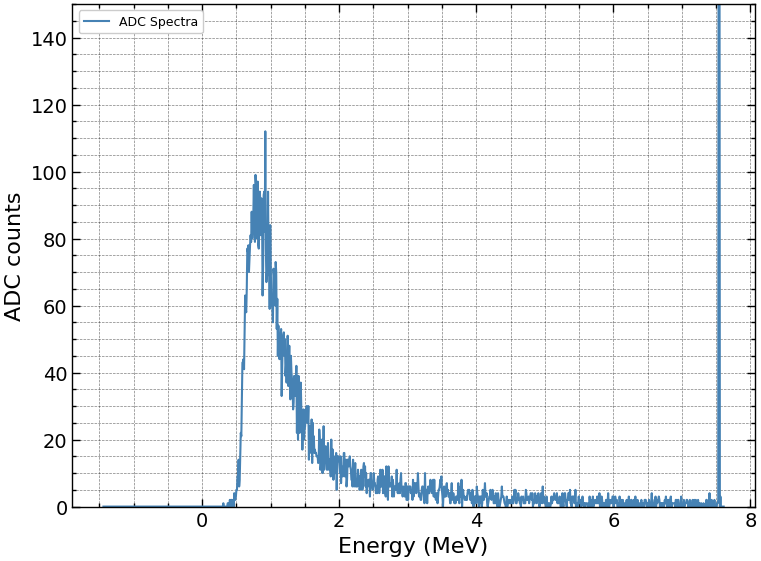

(array([-1.439399, -1.431447, -1.423495, ...,  7.594073,  7.602025,
         7.609977]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [68]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-on/free_spectra_lightON_chA_adc_a.txt",
    # xlim=(100, 800),
    ylim=(0, 150),
    cal_pmt_a=True,
    line_type="line",
)

Moyal Fit Parameters:
Mu (Location): 287.5942839986042
Sigma (Scale): 21.73125879296454
Amplitude: 7467.850853425032
FWHM: 78.02677165214249
Right FWHM intersection at x = 337.2386


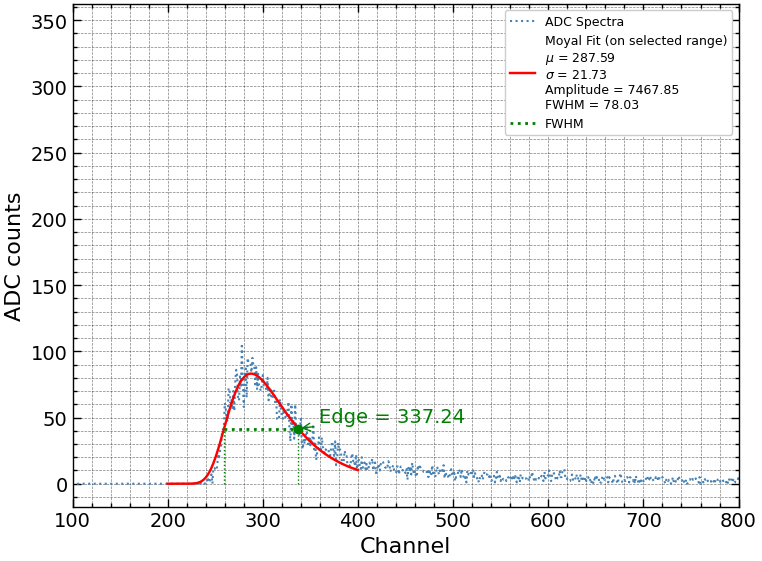

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.137e+03, 1.138e+03,
        1.139e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [24]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.3/light-off/free_spectra_lightOFF_chA_adc_a.txt",
    xlim=(100, 800),
    # ylim=(0, 0.45),
    FWHM=True,
    normalize_y=False,
)

## Section 5.1.4


### Time Calibration


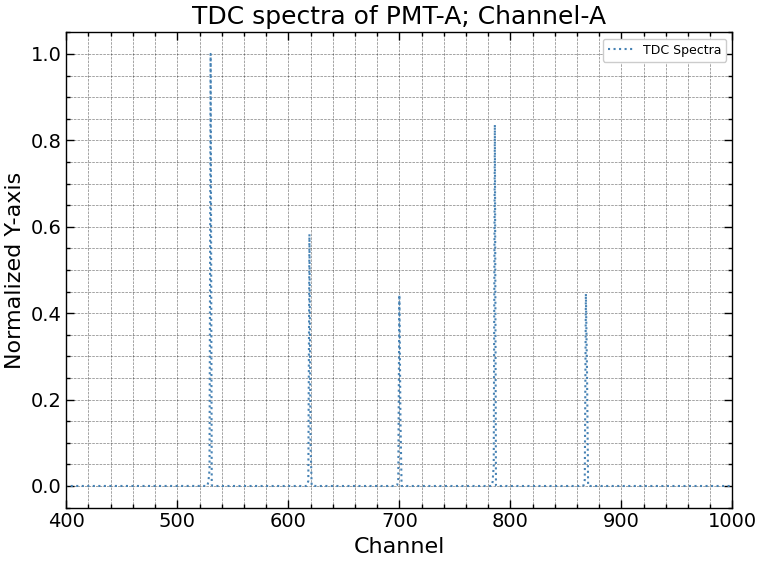

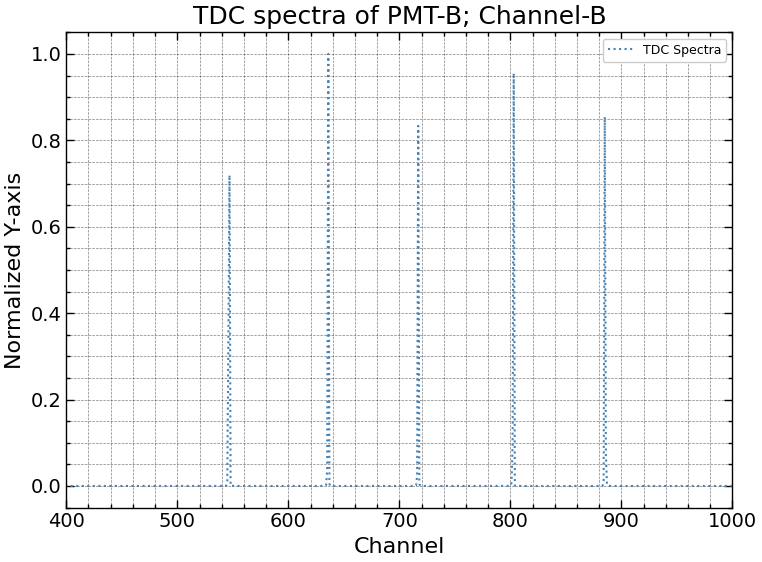

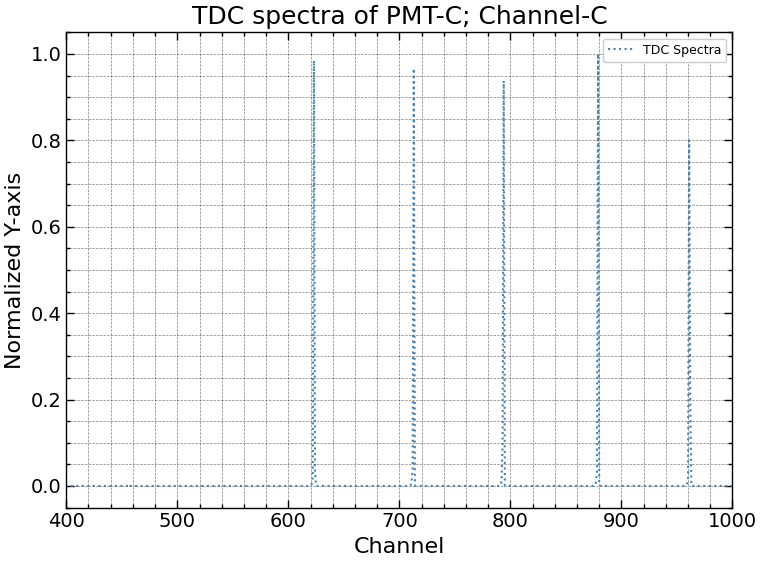

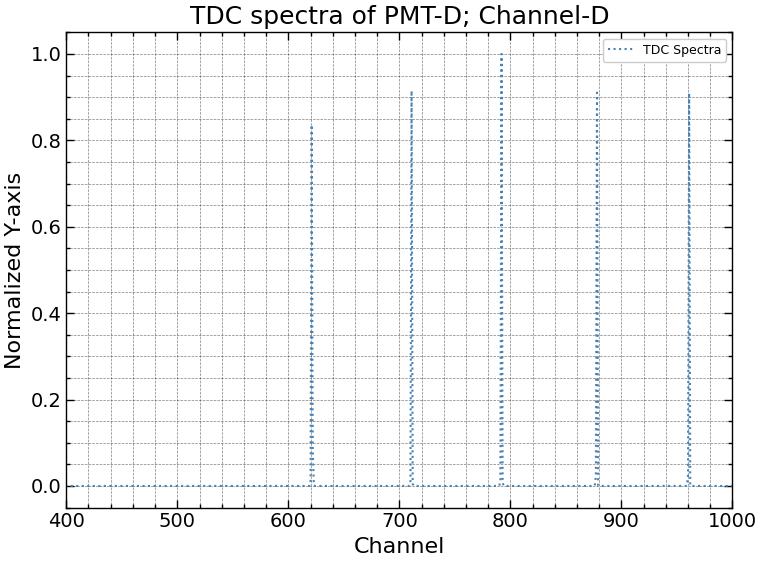

(array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.093e+03, 4.094e+03,
        4.095e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [25]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
    normalize_y=True,
)
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
)

In [26]:
# def analyze_tdc_spectrum(
#     file_path, xlim=None, ylim=None, normalize_y=False, save_pdf=False
# ):
#     # Load the data
#     data = np.loadtxt(file_path, delimiter="\t")
#     x, y = data[:, 0], data[:, 1]

#     # Normalize y if required
#     if normalize_y:
#         y = y / np.max(y)
#         y_label = "Normalized Y-axis"
#     else:
#         y_label = "TDC counts"

#     # Identify peaks
#     from scipy.signal import find_peaks

#     peaks, _ = find_peaks(
#         y, height=np.max(y) * 0.1
#     )  # Adjust height threshold as needed
#     peak_positions = x[peaks]
#     peak_heights = y[peaks]

#     # Sort peaks by channel (ascending) and reverse delays
#     sort_idx = np.argsort(peak_positions)
#     peak_positions = peak_positions[sort_idx]
#     peak_heights = peak_heights[sort_idx]

#     # Plot the TDC spectrum with identified peaks
#     plt.figure()
#     plt.plot(
#         x, y, label="TDC Spectrum", linestyle=":", color="steelblue", linewidth=1.5
#     )
#     plt.scatter(peak_positions, peak_heights, color="red", label="Peaks")
#     plt.xlabel("Channel No.")
#     plt.ylabel(y_label)
#     plt.title("TDC Spectrum with Identified Peaks")
#     plt.legend()
#     plt.grid(which="both", linestyle="--", linewidth=0.5)
#     if xlim is not None:
#         plt.xlim(xlim)
#     if ylim is not None:
#         plt.ylim(ylim)
#     plt.tight_layout()
#     if save_pdf:
#         pdf_filename = input(
#             "Enter filename to save PDF (e.g. 'TDC_Spectrum_with_Peaks.pdf'): "
#         )
#         if not pdf_filename.strip():
#             pdf_filename = "TDC_Spectrum_with_Peaks.pdf"
#         plt.savefig(pdf_filename, format="pdf")
#     plt.show()

#     # Use reversed time delays
#     time_delays = [16, 12, 8, 4, 0]
#     if len(peak_positions) != len(time_delays):
#         print("Number of peaks found does not match number of time delays!")
#         return

#     # Linear fit
#     from scipy.optimize import curve_fit

#     def linear_func(channel, slope, intercept):
#         return slope * channel + intercept

#     popt, pcov = curve_fit(linear_func, peak_positions, time_delays)
#     slope, intercept = popt
#     print(f"Linear Fit: Time (ns) = {slope:.4f} * Channel + {intercept:.4f}")

#     # Plot channel vs time with linear fit
#     plt.figure()
#     plt.scatter(peak_positions, time_delays, color="blue", label="Data Points")
#     if xlim is not None:
#         fit_x = np.linspace(xlim[0], xlim[1], 500)
#         plt.xlim(xlim)
#     else:
#         fit_x = np.linspace(np.min(x), np.max(x), 500)
#     plt.plot(
#         fit_x,
#         linear_func(fit_x, *popt),
#         color="red",
#         linestyle="--",
#         label=f"Linear Fit: Time = {slope:.4f} * Channel + {intercept:.4f}",
#     )
#     plt.xlabel("Channel No.")
#     plt.ylabel("Time (ns)")
#     plt.title("Channel vs Time with Linear Fit")
#     plt.legend()
#     plt.grid(which="both", linestyle="--", linewidth=0.5)
#     plt.tight_layout()
#     if save_pdf:
#         pdf_filename = input("Enter filename to save PDF (e.g. 'TDC_Linear_Fit.pdf'): ")
#         if not pdf_filename.strip():
#             pdf_filename = "TDC_Linear_Fit.pdf"
#         plt.savefig(pdf_filename, format="pdf")
#     plt.show()

#     return peak_positions, time_delays, slope, intercept

#### Channel-A PMT-A


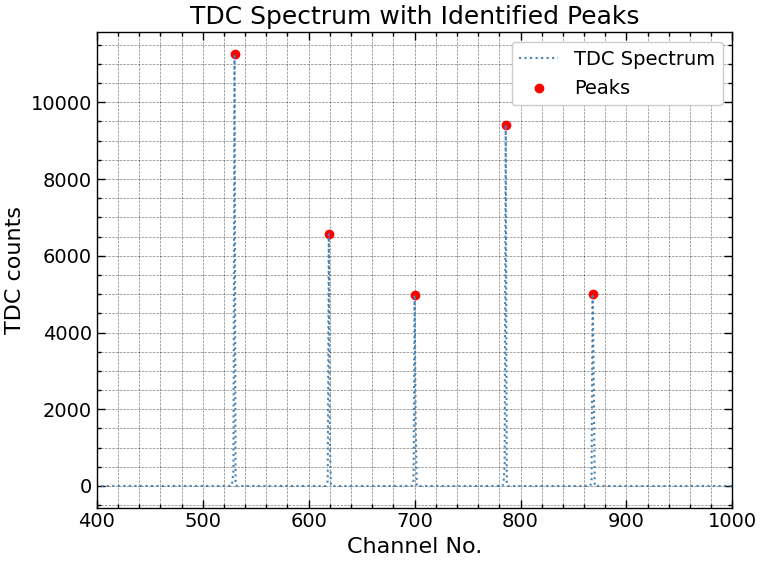

Linear Fit: Time (ns) = -0.0474 * Channel + 41.2365


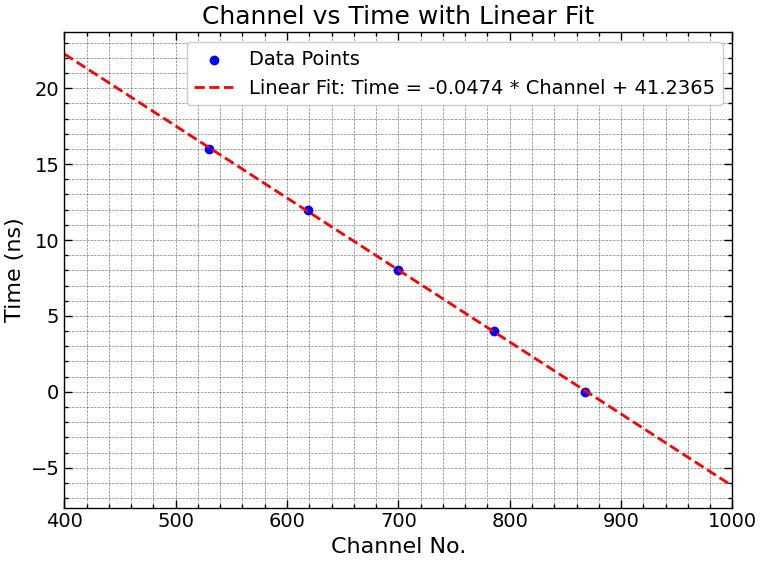

(array([530., 619., 700., 786., 868.]),
 [16, 12, 8, 4, 0],
 -0.04744003871492179,
 41.236491123674206)

In [27]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chA_tdc_a.txt",
    xlim=(400, 1000),
)

#### Channel-B PMT-B


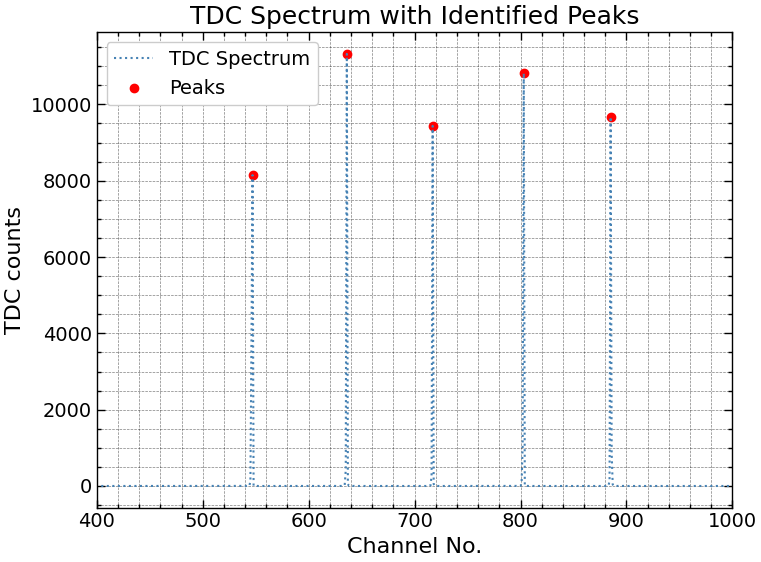

Linear Fit: Time (ns) = -0.0474 * Channel + 42.0430


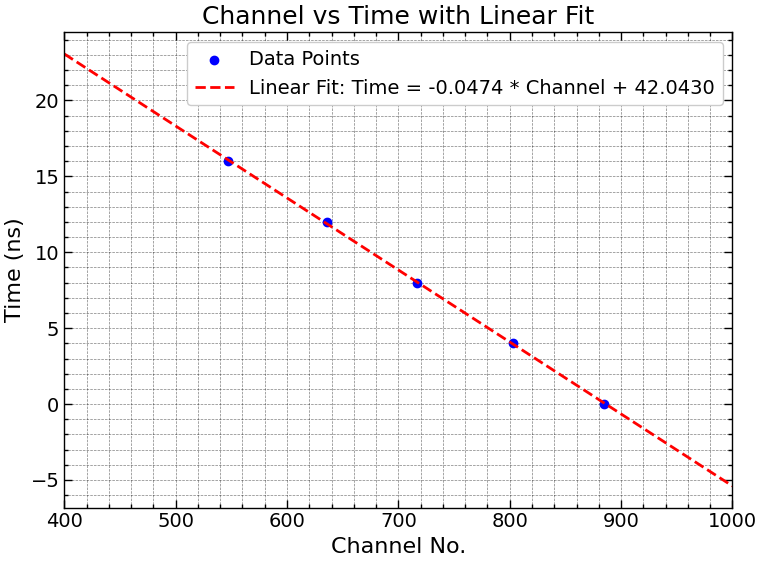

(array([547., 636., 717., 803., 885.]),
 [16, 12, 8, 4, 0],
 -0.04744003871965852,
 42.042971783677125)

In [28]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chB_tdc_b.txt",
    xlim=(400, 1000),
)

#### Channel-C PMT-C


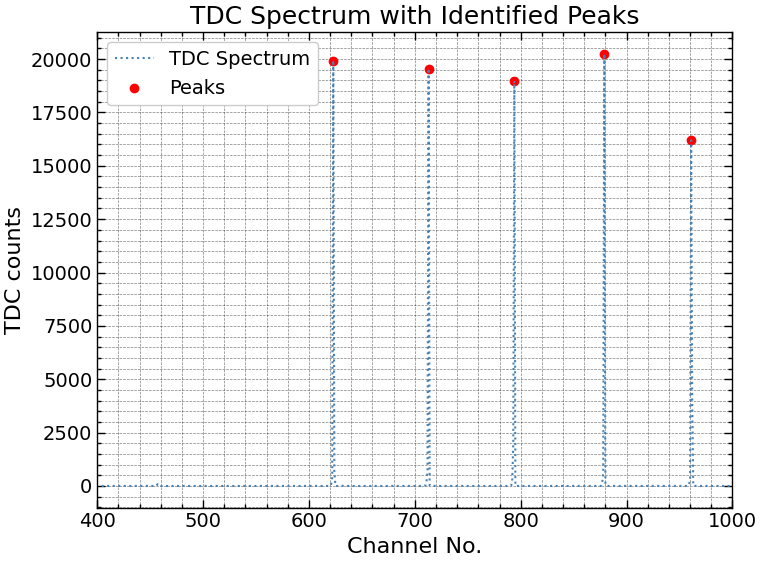

Linear Fit: Time (ns) = -0.0475 * Channel + 45.7093


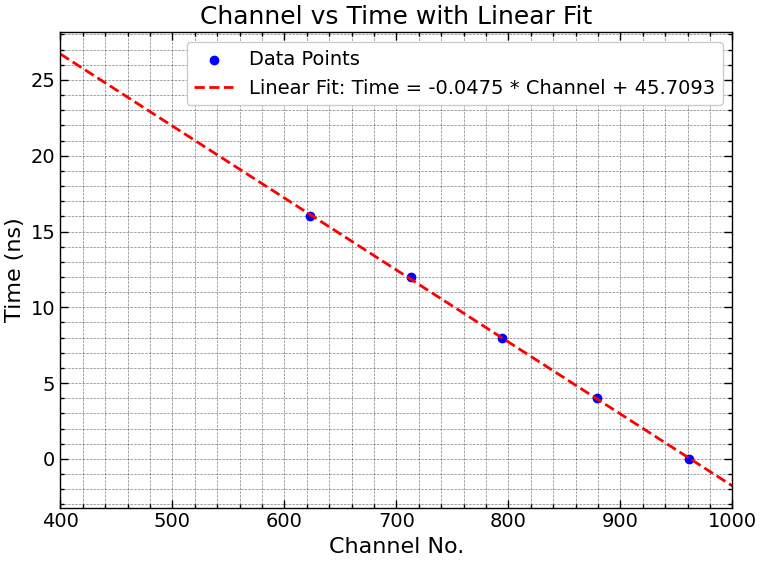

(array([623., 713., 794., 879., 961.]),
 [16, 12, 8, 4, 0],
 -0.04749280839421825,
 45.709289865009296)

In [29]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chC_tdc_c.txt",
    xlim=(400, 1000),
)

#### Channel-D PMT-D


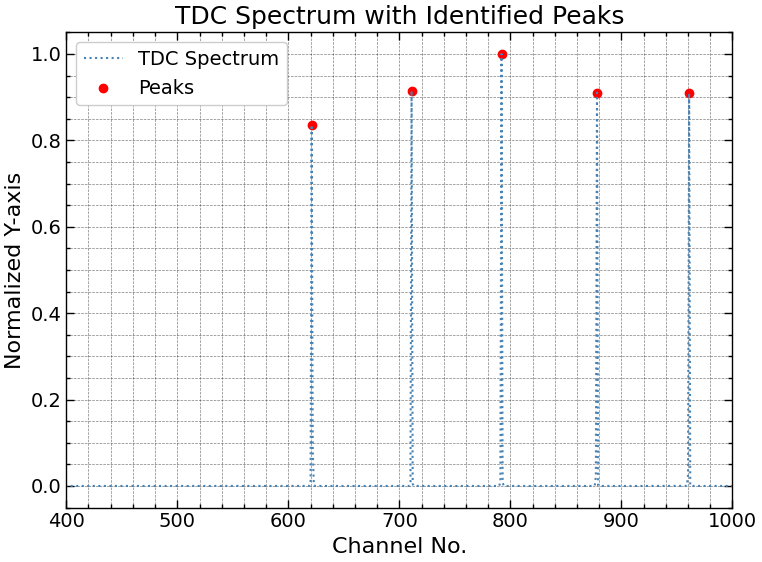

Linear Fit: Time (ns) = -0.0472 * Channel + 45.4224


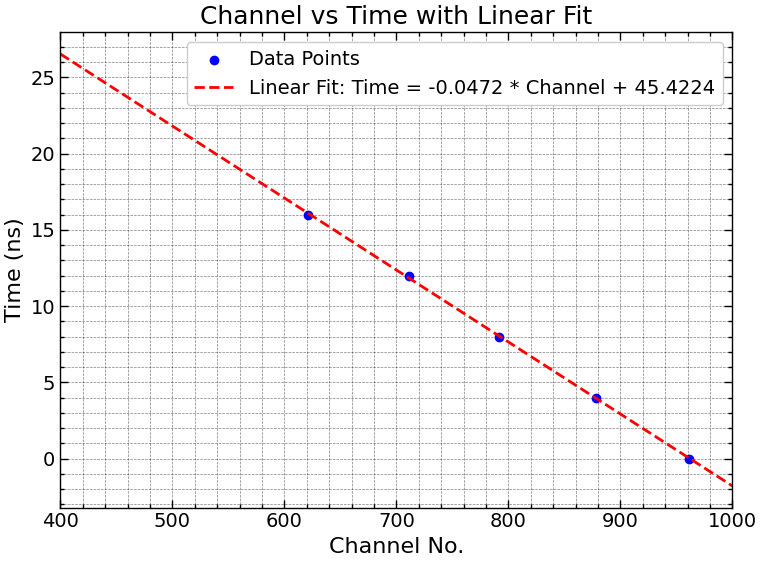

(array([621., 711., 792., 878., 961.]),
 [16, 12, 8, 4, 0],
 -0.04721477426883891,
 45.4224300837682)

In [31]:
analyze_tdc_spectrum(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/time calib/co60_time_calib_chD_tdc_d.txt",
    xlim=(400, 1000),
    normalize_y=True,
)

#### Time calibration linear fit functions of Channel A,B,C,D respectively:

A- Linear Fit: Time (ns) = -0.0474 _ Channel + 41.2365  
B- Linear Fit: Time (ns) = -0.0474 _ Channel + 42.0430  
C- Linear Fit: Time (ns) = -0.0475 _ Channel + 45.7093  
D- Linear Fit: Time (ns) = -0.0472 _ Channel + 45.4224


### Energy Calibration


#### Channel-A PMT-A



--- Moyal Fit Parameters ---
μ (peak position): 279.037 ± 0.194
σ (width): 14.833 ± 0.144
Amplitude: 19069.4 ± 150.2

--- Calibration Fit Parameters ---
Slope: 0.007952 ± inf
Intercept: -1.447351 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 182.00
Compton edge channel: 312.90


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


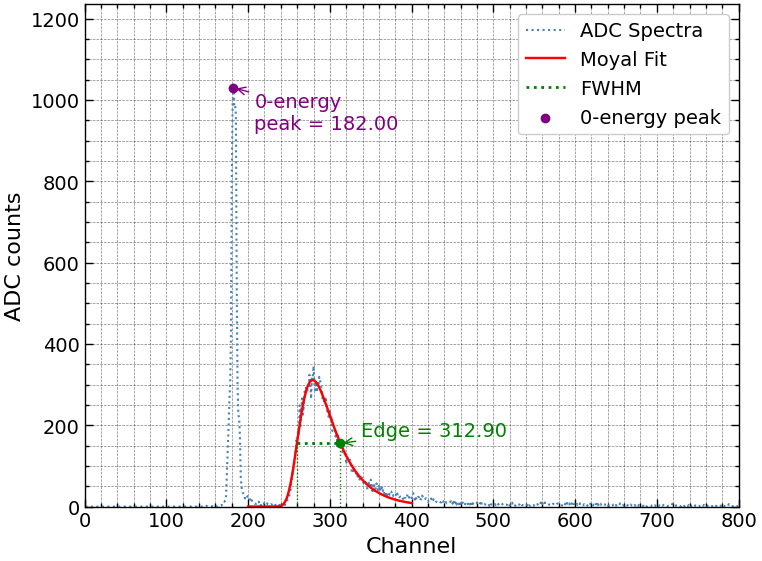

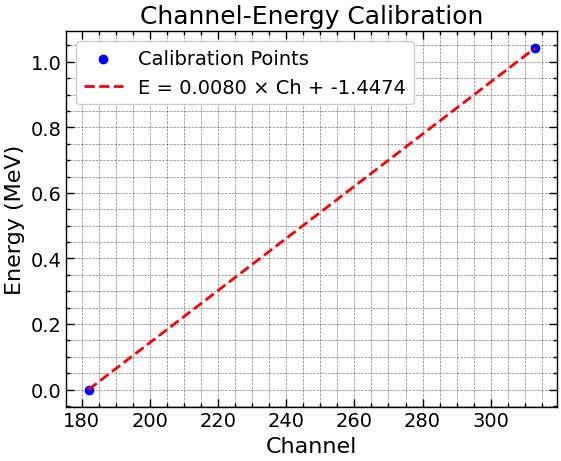

(0.007952478827351608, -1.4473511465779927)

In [160]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chA_adc_a.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)


--- Moyal Fit Parameters ---
μ (peak position): 276.195 ± 0.159
σ (width): 13.925 ± 0.118
Amplitude: 21053.1 ± 145.1

--- Calibration Fit Parameters ---
Slope: 0.002750 ± inf
Intercept: -0.506075 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 184.00
Compton edge channel: 307.98


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


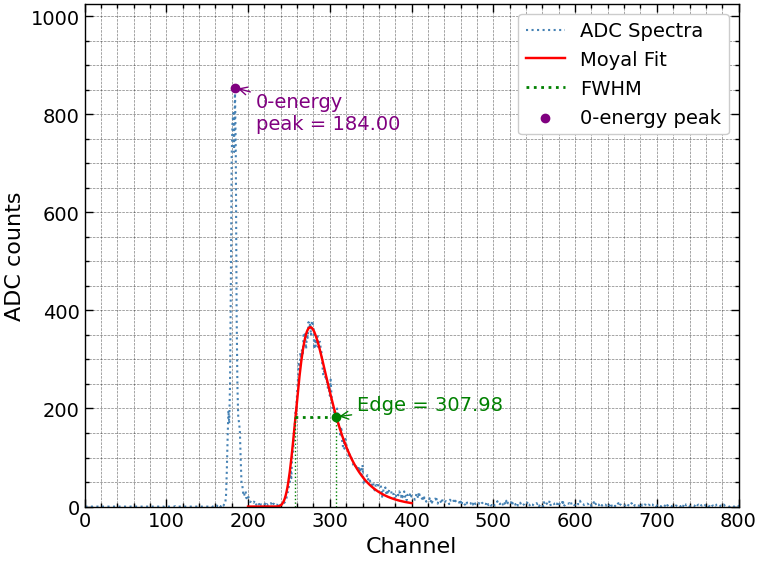

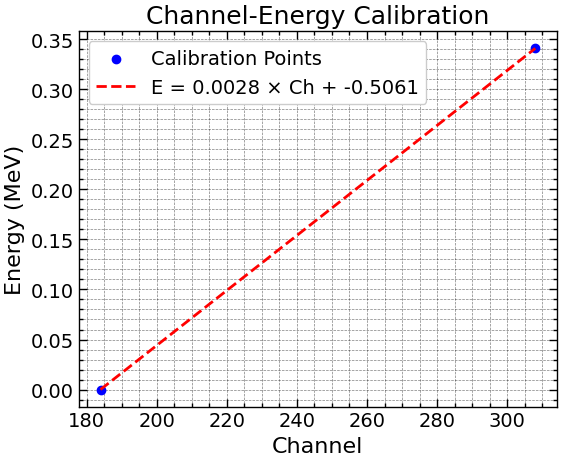

(0.002750408206730087, -0.506075110038336)

In [161]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Na22_chA_adc_a.txt",
    compton_edge="Na22",
    xlim=(0, 800),
)

#### Channel-B PMT-B



--- Moyal Fit Parameters ---
μ (peak position): 145.328 ± 0.207
σ (width): 12.924 ± 0.154
Amplitude: 22103.7 ± 213.7

--- Calibration Fit Parameters ---
Slope: 0.010427 ± inf
Intercept: -0.782041 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 75.00
Compton edge channel: 174.83


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


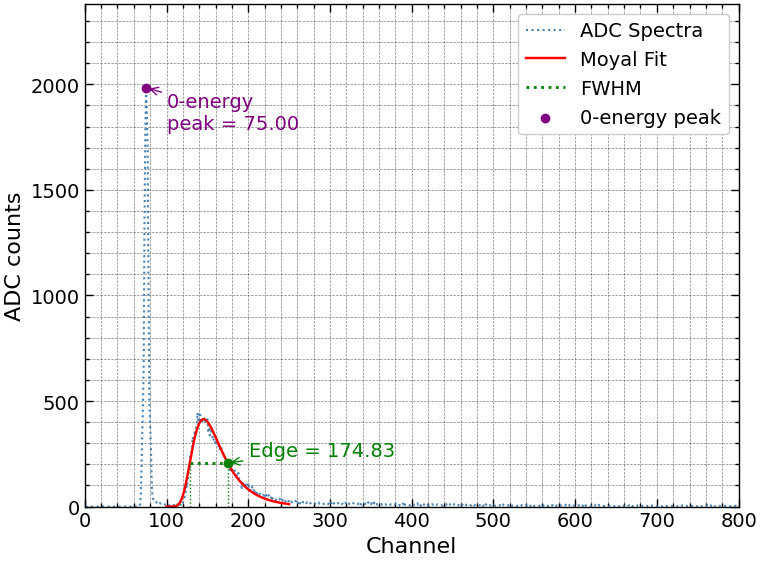

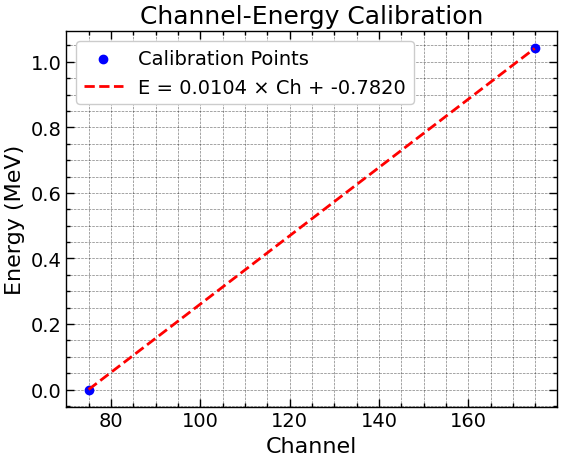

(0.010427208335420528, -0.7820406251565396)

In [162]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chB_adc_b.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)


--- Moyal Fit Parameters ---
μ (peak position): 145.600 ± 0.223
σ (width): 12.877 ± 0.166
Amplitude: 23360.1 ± 244.4

--- Calibration Fit Parameters ---
Slope: 0.003409 ± inf
Intercept: -0.255712 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 75.00
Compton edge channel: 175.02


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


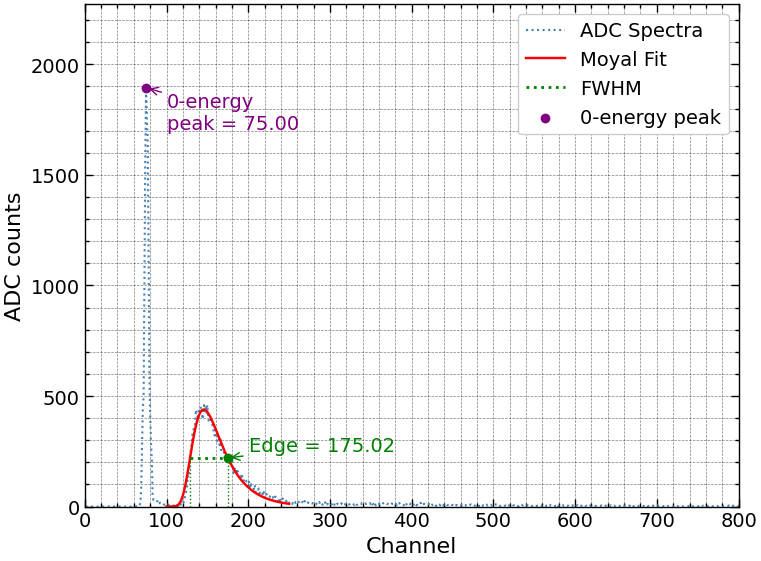

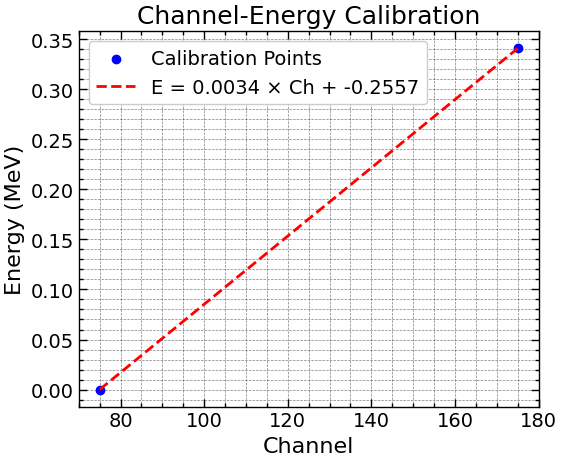

(0.0034094884744237204, -0.255711635581779)

In [168]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Na22_chB_adc_b.txt",
    compton_edge="Na22",
    xlim=(0, 800),
)

#### Channel-C PMT-C



--- Moyal Fit Parameters ---
μ (peak position): 186.561 ± 0.126
σ (width): 13.138 ± 0.093
Amplitude: 34830.4 ± 200.7

--- Calibration Fit Parameters ---
Slope: 0.011131 ± inf
Intercept: -1.369073 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 123.00
Compton edge channel: 216.53


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


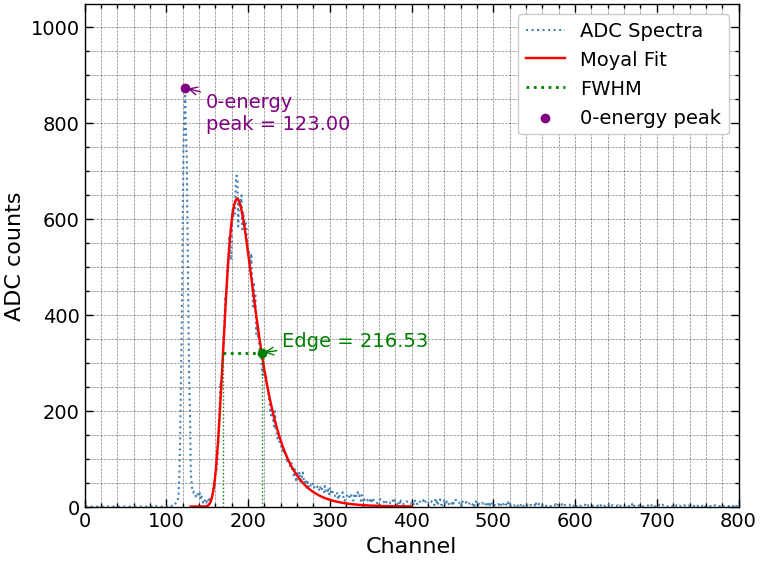

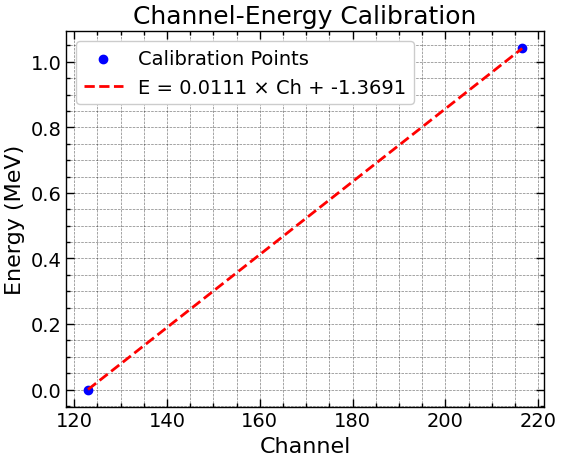

(0.011130677406728509, -1.3690733210276067)

In [167]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chC_adc_c.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)


--- Moyal Fit Parameters ---
μ (peak position): 187.280 ± 0.121
σ (width): 12.982 ± 0.090
Amplitude: 34620.7 ± 194.7

--- Calibration Fit Parameters ---
Slope: 0.003670 ± inf
Intercept: -0.455140 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 124.00
Compton edge channel: 216.90


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


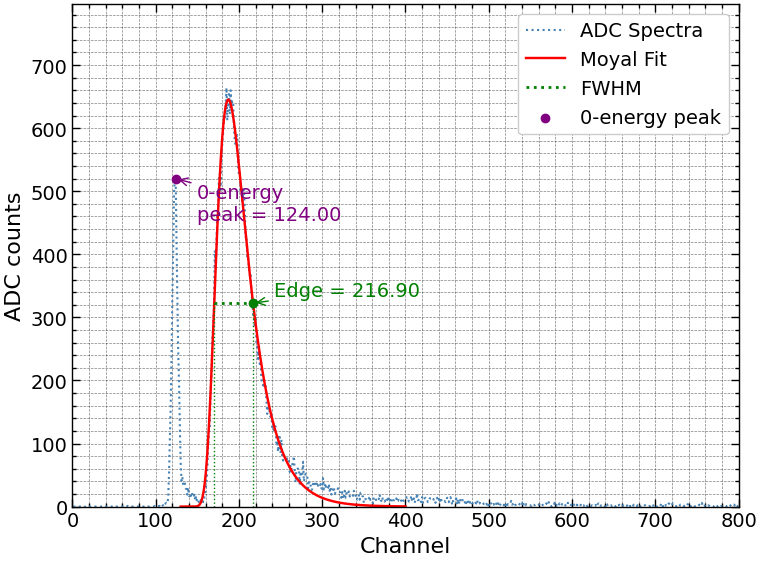

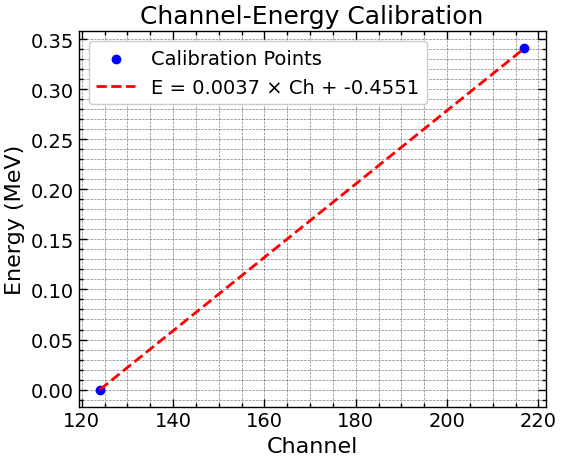

(0.00367047999242072, -0.4551395190601693)

In [170]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Na22_chC_adc_c.txt",
    compton_edge="Na22",
    xlim=(0, 800),
)

#### Channel-D PMT-D



--- Moyal Fit Parameters ---
μ (peak position): 209.765 ± 0.136
σ (width): 12.693 ± 0.101
Amplitude: 44627.7 ± 288.3

--- Calibration Fit Parameters ---
Slope: 0.012002 ± inf
Intercept: -1.824258 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 152.00
Compton edge channel: 238.74


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


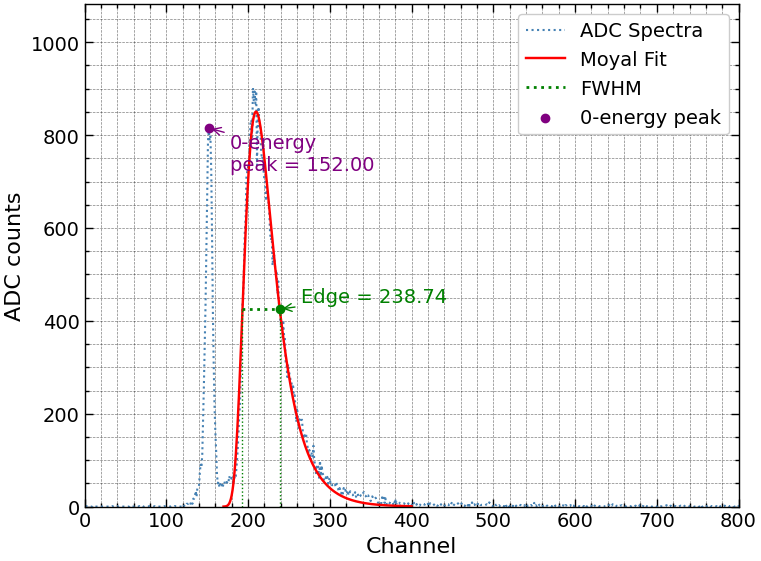

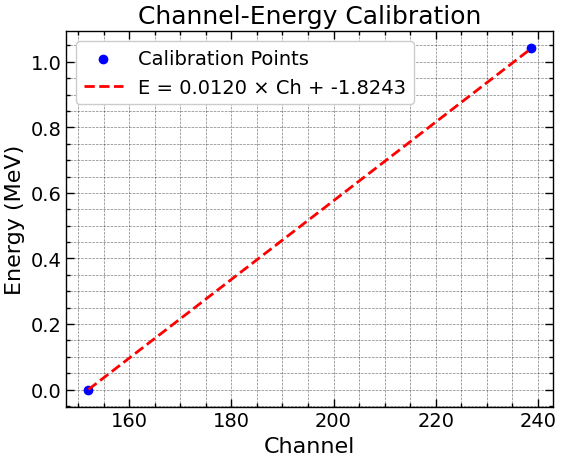

(0.012001695102882366, -1.8242576556381196)

In [172]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Co60_chD_adc_d.txt",
    compton_edge="Co60",
    xlim=(0, 800),
)

Invalid input for 0-energy peak x-range. Using auto-detect.

--- Moyal Fit Parameters ---
μ (peak position): 209.298 ± 0.134
σ (width): 12.324 ± 0.099
Amplitude: 42913.7 ± 281.6

--- Calibration Fit Parameters ---
Slope: 0.003991 ± inf
Intercept: -0.606581 ± inf

--- Peak & Edge Values ---
0-energy peak channel: 152.00
Compton edge channel: 237.45


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2204544872.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(linear_func, channels, energies)


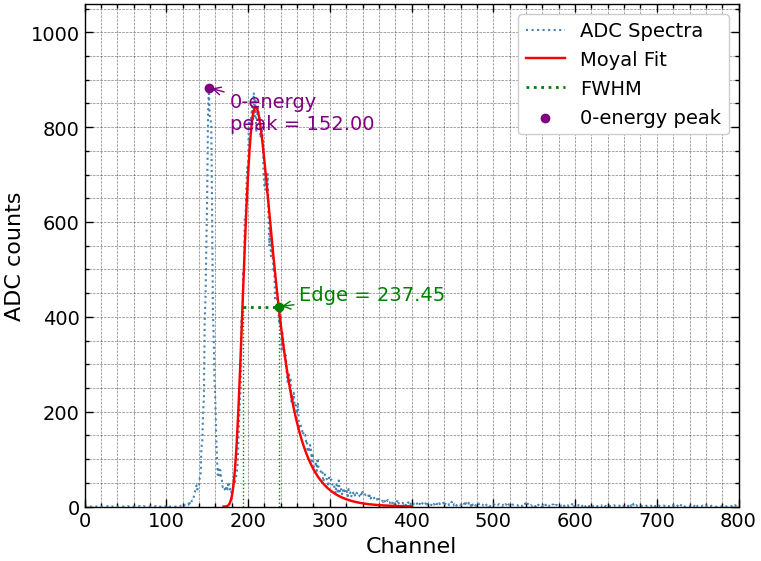

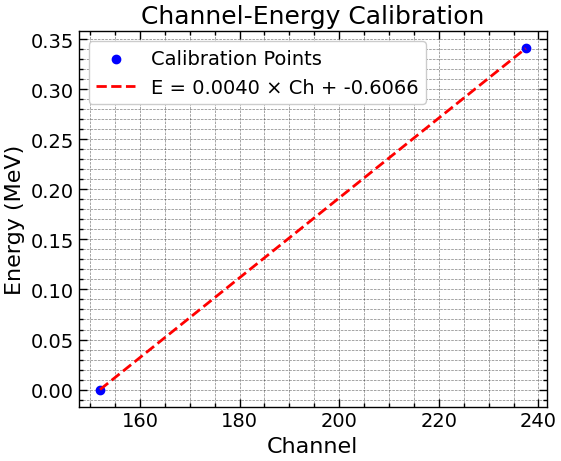

(0.003990661622522602, -0.6065805666234355)

In [173]:
energy_channel_calibration(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.4/energy calib/energy_calib_Na22_chD_adc_d.txt",
    compton_edge="Na22",
    xlim=(0, 800),
)

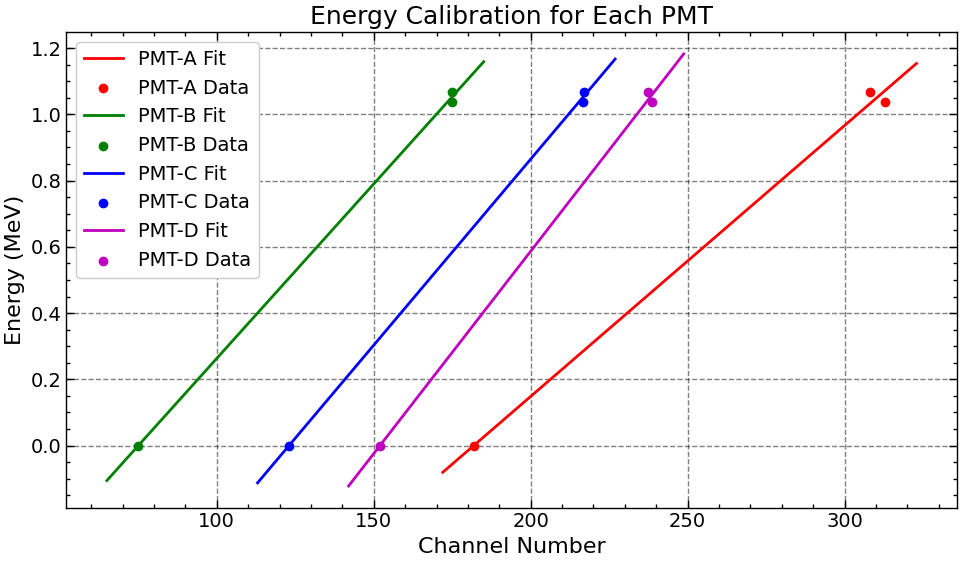

PMT-A: Slope = 0.00818 ± 0.00047, Intercept = -1.487 ± 0.128
PMT-B: Slope = 0.01053 ± 0.00023, Intercept = -0.790 ± 0.035
PMT-C: Slope = 0.01123 ± 0.00023, Intercept = -1.382 ± 0.044
PMT-D: Slope = 0.01222 ± 0.00045, Intercept = -1.857 ± 0.096


In [174]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Channel numbers extracted from the image
channel_data = {
    "PMT-A": [182, 312.9, 307.98],
    "PMT-B": [75, 174.83, 175.02],
    "PMT-C": [123, 216.53, 216.9],
    "PMT-D": [152, 238.74, 237.45],
}

# Corresponding energies (in MeV)
energy_data = [0, 1.038, 1.067]  # 0-Energy, Co-60 Compton, Na-22 Compton


# Linear function
def linear(x, m, c):
    return m * x + c


# Plot setup
plt.figure(figsize=(10, 6))
colors = ["r", "g", "b", "m"]
fit_params = {}

# Fit each PMT
for i, (pmt, channels) in enumerate(channel_data.items()):
    xdata = np.array(channels)
    ydata = np.array(energy_data)

    popt, pcov = curve_fit(linear, xdata, ydata)
    perr = np.sqrt(np.diag(pcov))  # Uncertainties

    fit_params[pmt] = {"slope": (popt[0], perr[0]), "intercept": (popt[1], perr[1])}

    # Plot
    x_fit = np.linspace(min(xdata) - 10, max(xdata) + 10, 100)
    plt.plot(x_fit, linear(x_fit, *popt), colors[i], label=f"{pmt} Fit")
    plt.scatter(xdata, ydata, color=colors[i], label=f"{pmt} Data")

plt.xlabel("Channel Number")
plt.ylabel("Energy (MeV)")
plt.title("Energy Calibration for Each PMT")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print fit parameters
for pmt, params in fit_params.items():
    m, dm = params["slope"]
    c, dc = params["intercept"]
    print(f"{pmt}: Slope = {m:.5f} ± {dm:.5f}, Intercept = {c:.3f} ± {dc:.3f}")

#### Energy-channel calibration linear fit functions of Channel A,B,C,D respectively:

| PMT   | Slope (MeV/channel) | Intercept (MeV) |
| ----- | ------------------- | --------------- |
| PMT-A | 0.00818 ± 0.00047   | -1.487 ± 0.128  |
| PMT-B | 0.01053 ± 0.00023   | -0.790 ± 0.035  |
| PMT-C | 0.01123 ± 0.00023   | -1.382 ± 0.044  |
| PMT-D | 0.01222 ± 0.00045   | -1.857 ± 0.096  |


## Section 5.1.5


### Overlap Coincidence


Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


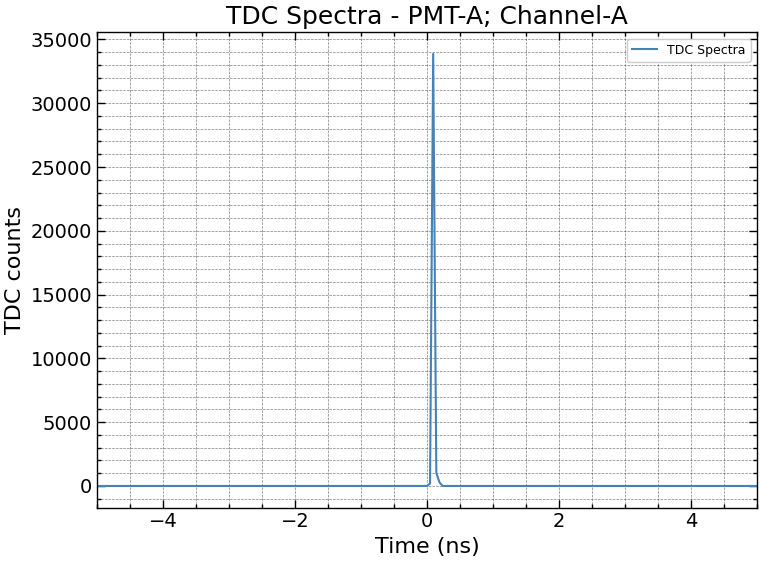

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [38]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA_without_delay_tdc_a.txt",
    cal_pmt_a=True,
    xlim=(-5, 5),
    line_type="line",
)

Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


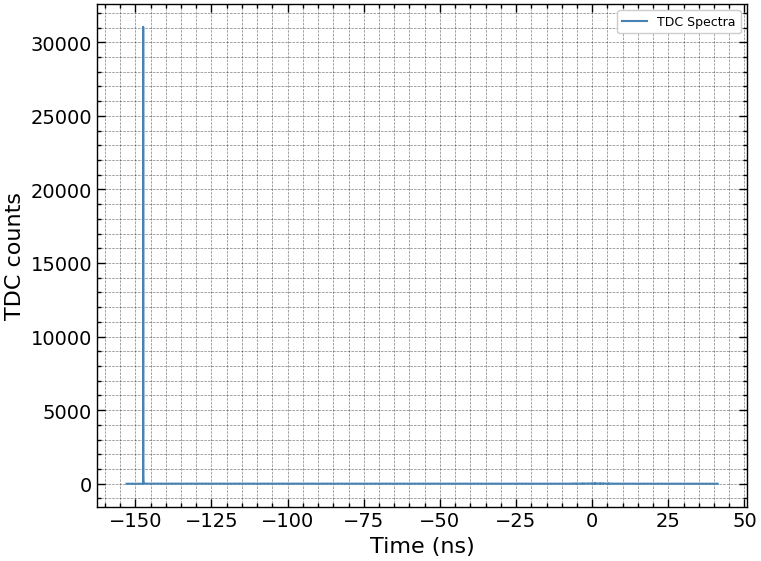

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [157]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA_without_delay_tdc_b.txt",
    cal_pmt_a=True,
    line_type="line",
)

Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


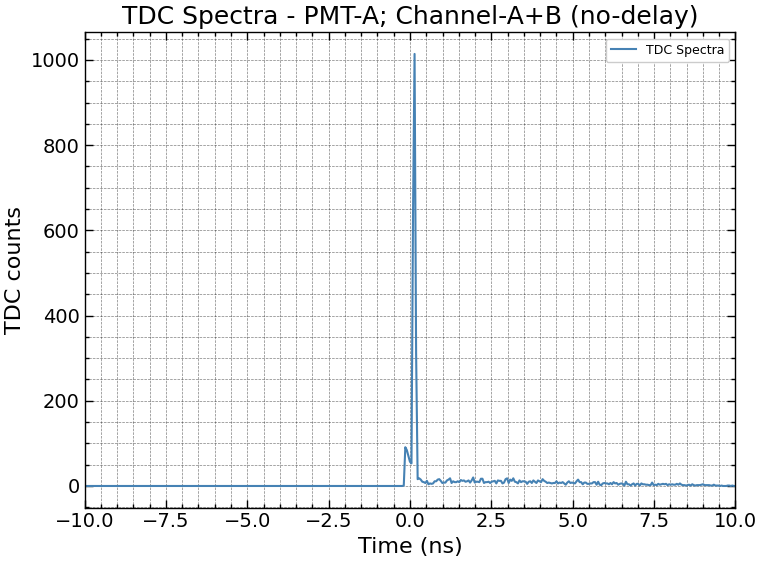

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [45]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_without_delay_tdc_a.txt",
    cal_pmt_a=True,
    line_type="line",
    xlim=(-10, 10),
)

Calibration used: PMT-B: Time (ns) = -0.0474 * Channel + 42.0430


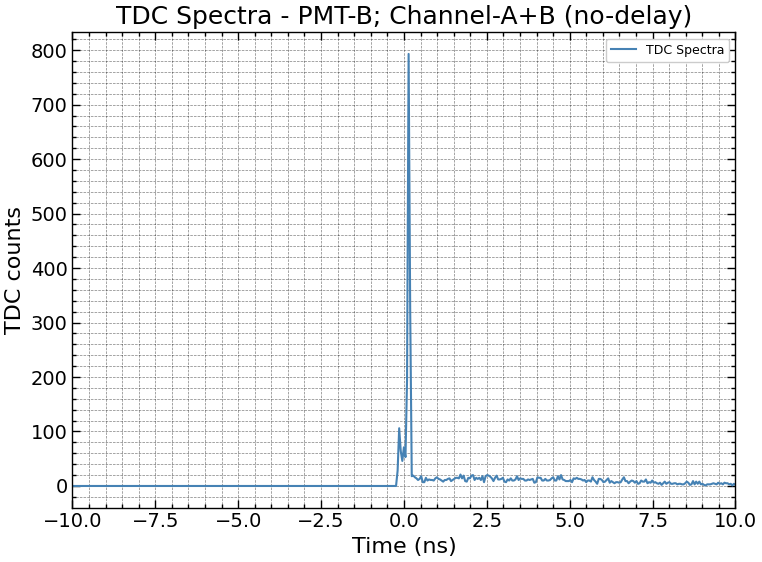

(array([  41.9956,   41.9482,   41.9008, ..., -151.9652, -152.0126,
        -152.06  ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [44]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_without_delay_tdc_b.txt",
    cal_pmt_b=True,
    line_type="line",
    xlim=(-10, 10),
)

Calibration used: PMT-A: Time (ns) = -0.0474 * Channel + 41.2365


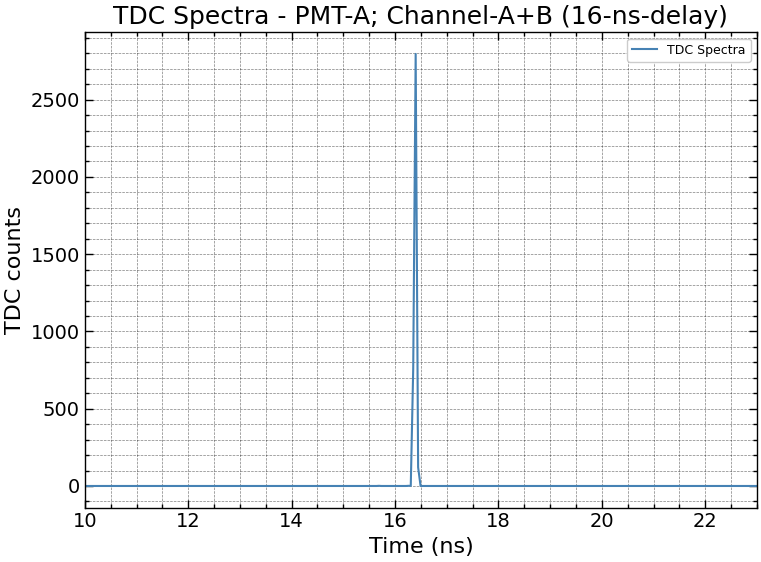

(array([  41.1891,   41.1417,   41.0943, ..., -152.7717, -152.8191,
        -152.8665]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [57]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_with_delay_tdc_a.txt",
    cal_pmt_a=True,
    line_type="line",
    xlim=(10, 23),
)

Calibration used: PMT-B: Time (ns) = -0.0474 * Channel + 42.0430


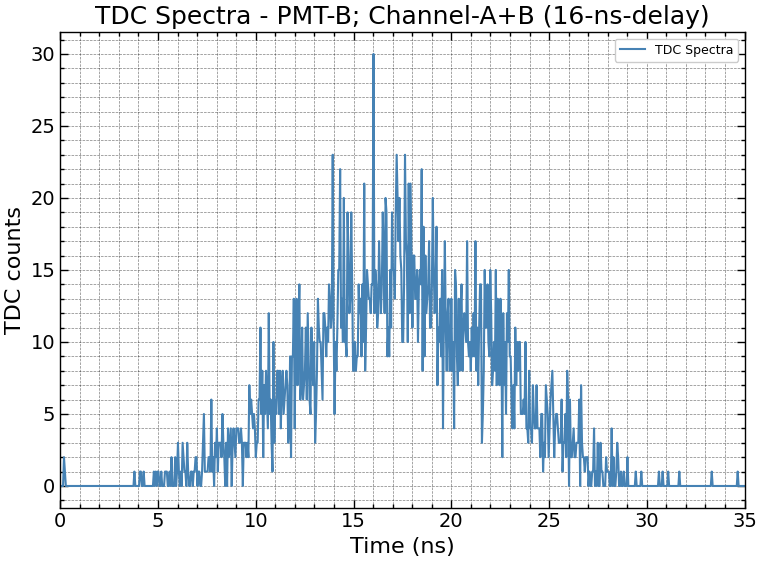

(array([  41.9956,   41.9482,   41.9008, ..., -151.9652, -152.0126,
        -152.06  ]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [61]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.1.5/sec5_1_5_concA+B_with_delay_tdc_b.txt",
    cal_pmt_b=True,
    line_type="line",
    xlim=(0, 35),
)

## Section 5.2.1


### Attenuation in the Scintillator


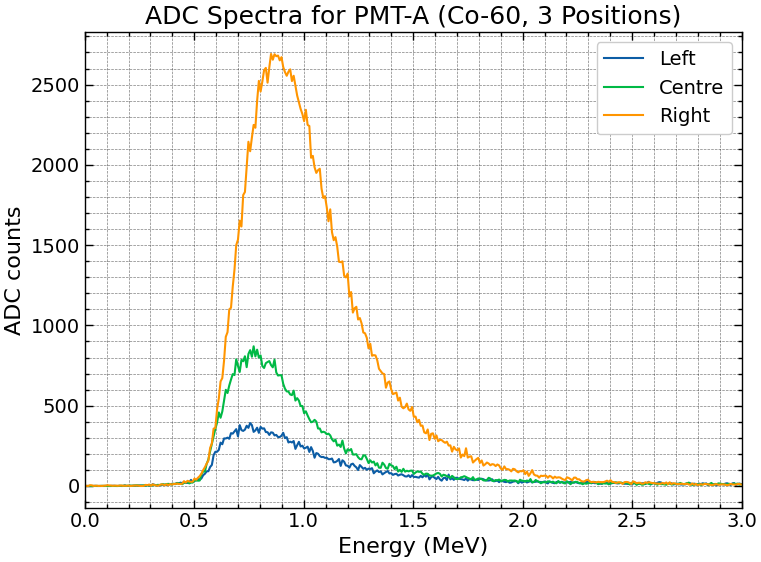

In [79]:
import numpy as np
import matplotlib.pyplot as plt


# Calibration for PMT-A (from your earlier results)
def cal_pmt_a(x):
    return 0.007952 * x + -1.447351


# File paths for the 3 positions (replace with your actual file names)
file1 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_positionA_left_adc_a.txt"
file2 = (
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_position_adc_a.txt"
)
file3 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_positionA_right_adc_a.txt"

# Load data
x1, y1 = np.loadtxt(file1, delimiter="\t", unpack=True)
x2, y2 = np.loadtxt(file2, delimiter="\t", unpack=True)
x3, y3 = np.loadtxt(file3, delimiter="\t", unpack=True)

# Apply calibration
energy1 = cal_pmt_a(x1)
energy2 = cal_pmt_a(x2)
energy3 = cal_pmt_a(x3)

# Plot all three spectra
plt.figure(figsize=(8, 6))
plt.plot(energy1, y1, label="Left", linestyle="-", linewidth=1.5)
plt.plot(energy2, y2, label="Centre", linestyle="-", linewidth=1.5)
plt.plot(energy3, y3, label="Right", linestyle="-", linewidth=1.5)
plt.xlabel("Energy (MeV)")
plt.ylabel("ADC counts")
plt.title("ADC Spectra for PMT-A (Co-60, 3 Positions)")
plt.legend()
plt.xlim(0, 3)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

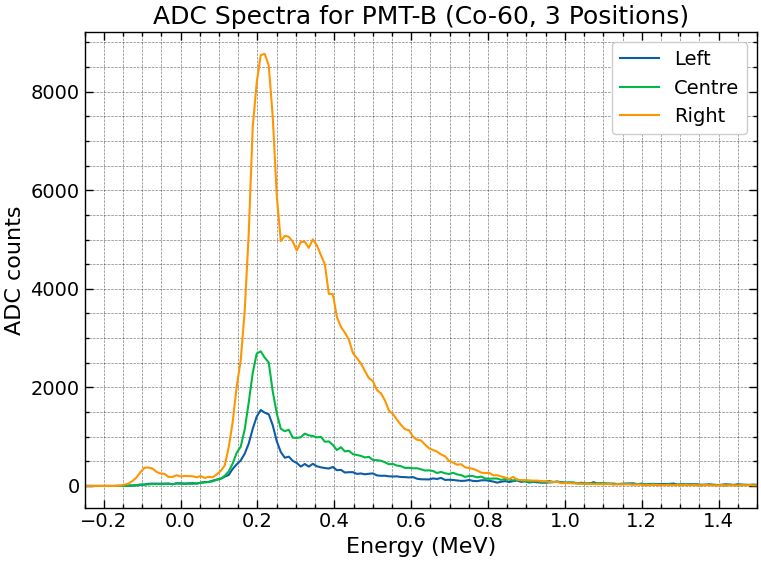

In [82]:
import numpy as np
import matplotlib.pyplot as plt


# Calibration for PMT-B (from your earlier results)
def cal_pmt_b(x):
    return 0.010427 * x + -0.782041


# File paths for the 3 positions (replace with your actual file names)
file1 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_positionA_left_adc_b.txt"
file2 = (
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_position_adc_b.txt"
)
file3 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_positionA_right_adc_b.txt"

# Load data
x1, y1 = np.loadtxt(file1, delimiter="\t", unpack=True)
x2, y2 = np.loadtxt(file2, delimiter="\t", unpack=True)
x3, y3 = np.loadtxt(file3, delimiter="\t", unpack=True)

# Apply calibration
energy1 = cal_pmt_b(x1)
energy2 = cal_pmt_b(x2)
energy3 = cal_pmt_b(x3)

# Plot all three spectra
plt.figure(figsize=(8, 6))
plt.plot(energy1, y1, label="Left", linestyle="-", linewidth=1.5)
plt.plot(energy2, y2, label="Centre", linestyle="-", linewidth=1.5)
plt.plot(energy3, y3, label="Right", linestyle="-", linewidth=1.5)
plt.xlabel("Energy (MeV)")
plt.ylabel("ADC counts")
plt.title("ADC Spectra for PMT-B (Co-60, 3 Positions)")
plt.legend()
plt.xlim(-0.25, 1.5)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## Section 5.2.2


### Free and coincident energy spectra


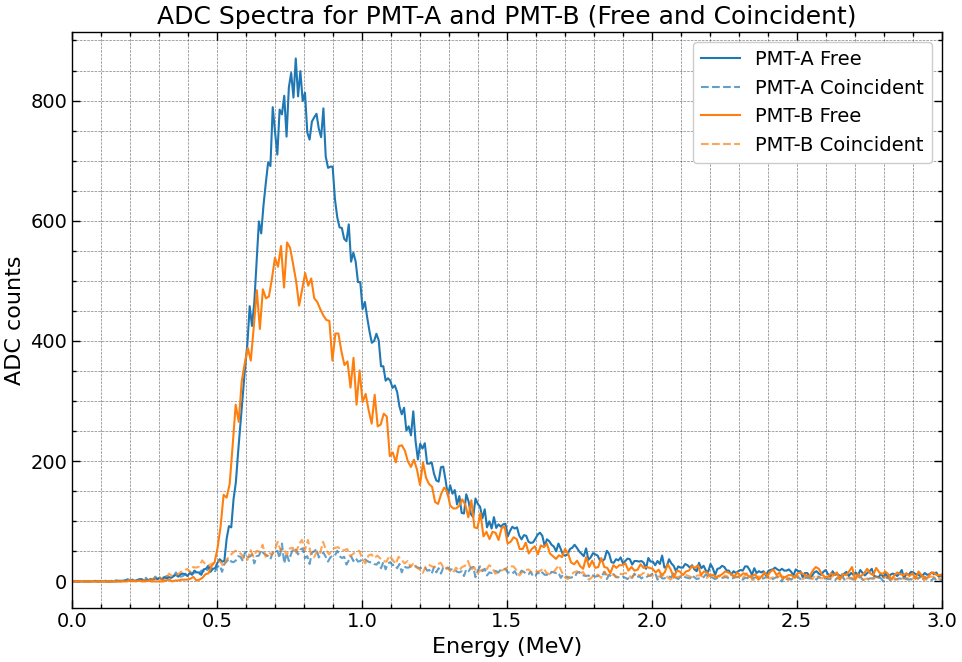

In [7]:
# --- Plot ADC spectra for PMT-A and PMT-B under free and coincident conditions, with optional x-shift ---

import numpy as np
import matplotlib.pyplot as plt


# Calibration functions
def cal_pmt_a(x):
    return 0.007952 * x + -1.447351


def cal_pmt_b(x):
    return 0.010427 * x + -0.782041


# File paths (replace with your actual file names)
# PMT-A
file_a_free = (
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_position_adc_a.txt"
)
file_a_coinc = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.2/co_60_middle_positionA+B_adc_a.txt"
# # PMT-B
file_b_free = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.2/test_adc_b.txt"
file_b_coinc = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.2/co_60_middle_positionA+B_adc_b.txt"

# Load data
x_a_free, y_a_free = np.loadtxt(file_a_free, delimiter="\t", unpack=True)
x_a_coinc, y_a_coinc = np.loadtxt(file_a_coinc, delimiter="\t", unpack=True)
x_b_free, y_b_free = np.loadtxt(file_b_free, delimiter="\t", unpack=True)
x_b_coinc, y_b_coinc = np.loadtxt(file_b_coinc, delimiter="\t", unpack=True)

# Apply calibration
energy_a_free = cal_pmt_a(x_a_free)
energy_a_coinc = cal_pmt_a(x_a_coinc)
energy_b_free = cal_pmt_b(x_b_free)
energy_b_coinc = cal_pmt_b(x_b_coinc)

# --- Shift values (in MeV) ---
shift_a_free = 0.0  # e.g., 0.05 to shift right, -0.05 to shift left
shift_a_coinc = 0.0
shift_b_free = 0.199
shift_b_coinc = 0.0

# Apply shifts
energy_a_free_shifted = energy_a_free + shift_a_free
energy_a_coinc_shifted = energy_a_coinc + shift_a_coinc
energy_b_free_shifted = energy_b_free + shift_b_free
energy_b_coinc_shifted = energy_b_coinc + shift_b_coinc

# Plot all four spectra
plt.figure(figsize=(10, 7))
plt.plot(
    energy_a_free_shifted,
    y_a_free,
    label="PMT-A Free",
    linestyle="-",
    linewidth=1.5,
    color="tab:blue",
)
plt.plot(
    energy_a_coinc_shifted,
    y_a_coinc,
    label="PMT-A Coincident",
    linestyle="--",
    linewidth=1.5,
    color="tab:blue",
    alpha=0.7,
)
plt.plot(
    energy_b_free_shifted,
    y_b_free * 1.5,
    label="PMT-B Free",
    linestyle="-",
    linewidth=1.5,
    color="tab:orange",
)
plt.plot(
    energy_b_coinc_shifted,
    y_b_coinc,
    label="PMT-B Coincident",
    linestyle="--",
    linewidth=1.5,
    color="tab:orange",
    alpha=0.7,
)
plt.xlabel("Energy (MeV)")
plt.ylabel("ADC counts")
plt.title("ADC Spectra for PMT-A and PMT-B (Free and Coincident)")
plt.legend()
plt.xlim(0, 3)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## OR


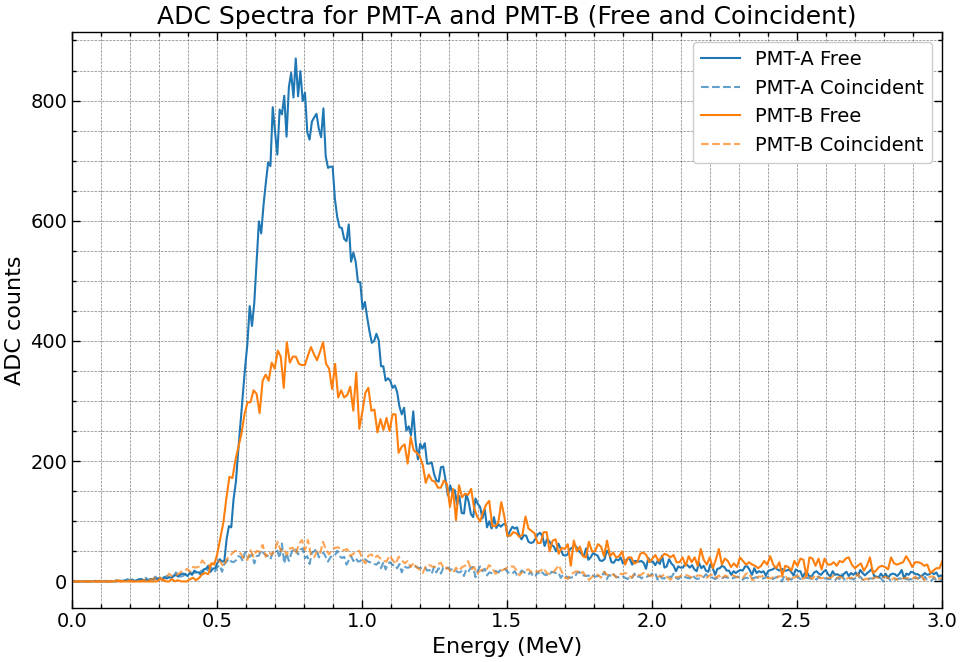

In [ ]:
# --- Plot ADC spectra for PMT-A and PMT-B under free and coincident conditions, with optional x-shift ---

import numpy as np
import matplotlib.pyplot as plt


# Calibration functions
def cal_pmt_a(x):
    return 0.007952 * x + -1.447351


def cal_pmt_b(x):
    return 0.010427 * x + -0.782041


# File paths (replace with your actual file names)
# PMT-A
file_a_free = (
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.1/co_60_middle_position_adc_a.txt"
)
file_a_coinc = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.2/co_60_middle_positionA+B_adc_a.txt"
# # PMT-B
file_b_free = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.2/test_adc_b.txt"
file_b_coinc = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.2/co_60_middle_positionA+B_adc_b.txt"

# Load data
x_a_free, y_a_free = np.loadtxt(file_a_free, delimiter="\t", unpack=True)
x_a_coinc, y_a_coinc = np.loadtxt(file_a_coinc, delimiter="\t", unpack=True)
x_b_free, y_b_free = np.loadtxt(file_b_free, delimiter="\t", unpack=True)
x_b_coinc, y_b_coinc = np.loadtxt(file_b_coinc, delimiter="\t", unpack=True)

# Apply calibration
energy_a_free = cal_pmt_a(x_a_free)
energy_a_coinc = cal_pmt_a(x_a_coinc)
energy_b_free = cal_pmt_b(x_b_free)
energy_b_coinc = cal_pmt_b(x_b_coinc)

# --- Shift values (in MeV) ---
shift_a_free = 0.0  # e.g., 0.05 to shift right, -0.05 to shift left
shift_a_coinc = 0.0
shift_b_free = 0.0
shift_b_coinc = 0.0

# Apply shifts
energy_a_free_shifted = energy_a_free + shift_a_free
energy_a_coinc_shifted = energy_a_coinc + shift_a_coinc
energy_b_free_shifted = energy_b_free + shift_b_free
energy_b_coinc_shifted = energy_b_coinc + shift_b_coinc

# Plot all four spectra
plt.figure(figsize=(10, 7))
plt.plot(
    energy_a_free_shifted,
    y_a_free,
    label="PMT-A Free",
    linestyle="-",
    linewidth=1.5,
    color="tab:blue",
)
plt.plot(
    energy_a_coinc_shifted,
    y_a_coinc,
    label="PMT-A Coincident",
    linestyle="--",
    linewidth=1.5,
    color="tab:blue",
    alpha=0.7,
)
plt.plot(
    energy_b_free_shifted,
    y_b_free * 2,
    label="PMT-B Free",
    linestyle="-",
    linewidth=1.5,
    color="tab:orange",
)
plt.plot(
    energy_b_coinc_shifted,
    y_b_coinc,
    label="PMT-B Coincident",
    linestyle="--",
    linewidth=1.5,
    color="tab:orange",
    alpha=0.7,
)
plt.xlabel("Energy (MeV)")
plt.ylabel("ADC counts")
plt.title("ADC Spectra for PMT-A and PMT-B (Free and Coincident)")
plt.legend()
plt.xlim(0, 3)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## Section 5.2.3


Left Gaussian Fit:
  Amplitude = 25.88 ± 0.14
  Mean      = 18.25 ± 0.03
  Sigma     = 5.02 ± 0.03

Center Gaussian Fit:
  Amplitude = 26.38 ± 0.12
  Mean      = 17.53 ± 0.03
  Sigma     = 4.82 ± 0.03

Right Gaussian Fit:
  Amplitude = 26.17 ± 0.14
  Mean      = 16.49 ± 0.03
  Sigma     = 5.11 ± 0.03



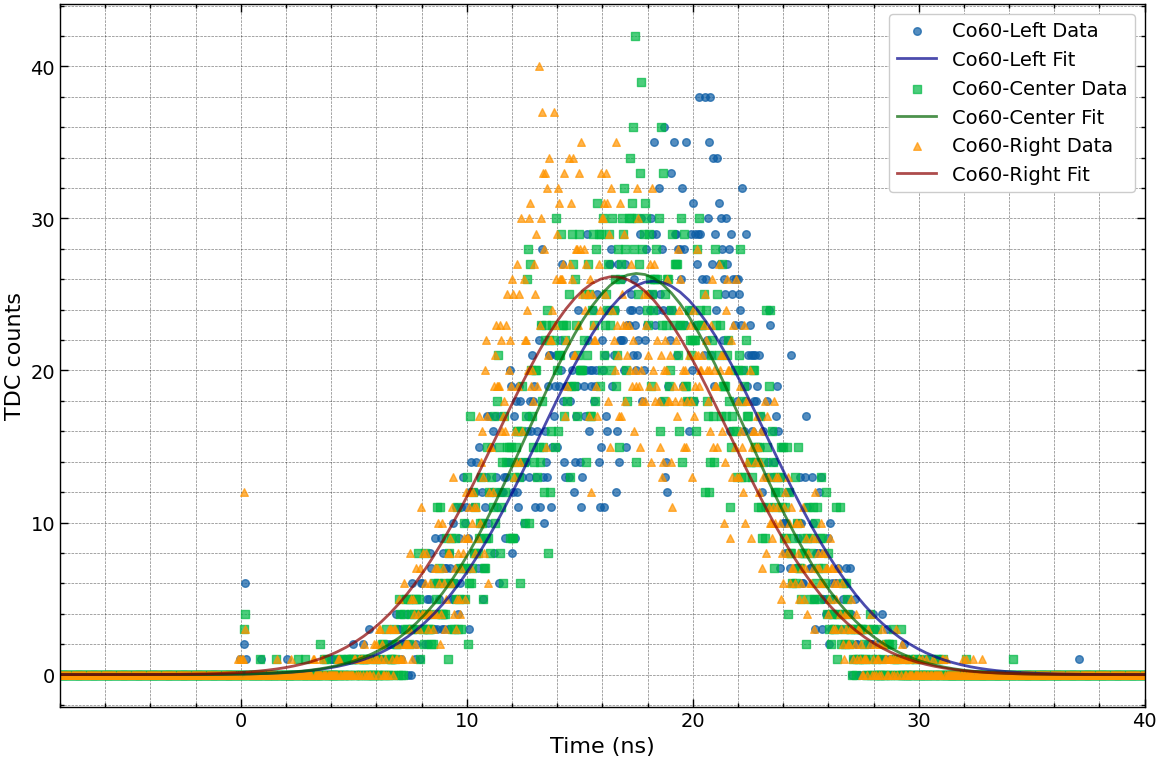

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


# Calibration for PMT-B
def cal_pmt_b(x):
    return -0.0474 * x + 42.0430


# File paths for the 3 positions
file1 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.3/co_60_A+B_positionA_left_tdc_b.txt"
file2 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.3/co_60_middle_positionA+B_tdc_b.txt"
file3 = "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.2.3/co_60_A+B_positionA_right_tdc_b.txt"

# Load data
x1, y1 = np.loadtxt(file1, delimiter="\t", unpack=True)
x2, y2 = np.loadtxt(file2, delimiter="\t", unpack=True)
x3, y3 = np.loadtxt(file3, delimiter="\t", unpack=True)

# Apply calibration
time1 = cal_pmt_b(x1)
time2 = cal_pmt_b(x2)
time3 = cal_pmt_b(x3)

# Define Gaussian fit colors
fit_colors = ["darkblue", "darkgreen", "darkred"]

# Prepare the plot
plt.figure(figsize=(12, 8))

# Fit and plot for each spectrum
positions_labels = ["Left", "Center", "Right"]
markers = ["o", "s", "^"]
for i, (time, y, pos_label, fit_color, marker) in enumerate(
    zip([time1, time2, time3], [y1, y2, y3], positions_labels, fit_colors, markers)
):
    # Initial guess: amplitude, mean, std
    p0 = [np.max(y), time[np.argmax(y)], np.std(time)]
    try:
        popt, pcov = curve_fit(gaussian, time, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
        print(f"{pos_label} Gaussian Fit:")
        print(f"  Amplitude = {popt[0]:.2f} ± {perr[0]:.2f}")
        print(f"  Mean      = {popt[1]:.2f} ± {perr[1]:.2f}")
        print(f"  Sigma     = {popt[2]:.2f} ± {perr[2]:.2f}\n")
        area = simps(gaussian(time, *popt), time)
        print(f"Total counts (area under fit for {pos_label}): {area:.2f}")

        # Plot data points
        plt.scatter(
            time, y, label=f"Co60-{pos_label} Data", s=30, marker=marker, alpha=0.7
        )

        # Plot the fitted Gaussian
        time_fit = np.linspace(min(time), max(time), 500)
        plt.plot(
            time_fit,
            gaussian(time_fit, *popt),
            label=f"Co60-{pos_label} Fit",
            color=fit_color,
            linewidth=2,
            alpha=0.7,
        )
    except Exception as e:
        print(f"{pos_label} Gaussian Fit failed: {e}\n")

plt.xlim(-8, 40)
plt.xlabel("Time (ns)")
plt.ylabel("TDC counts")
# plt.title("TDC Spectra for PMT-B (Co-60, 3 Positions)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## Section 5.3.1


### Detector Resolution


Calibration used: PMT-C: Time (ns) = -0.0475 * Channel + 45.7093
Gaussian Fit Parameters:
Amplitude = 49.86 ± 0.45
Mu = 21.34 ± 0.05
Sigma = 4.99 ± 0.05
Gaussian Fit Parameters:
Amplitude = 49.86 ± 0.45
Mu = 21.34 ± 0.05
Sigma = 4.99 ± 0.05


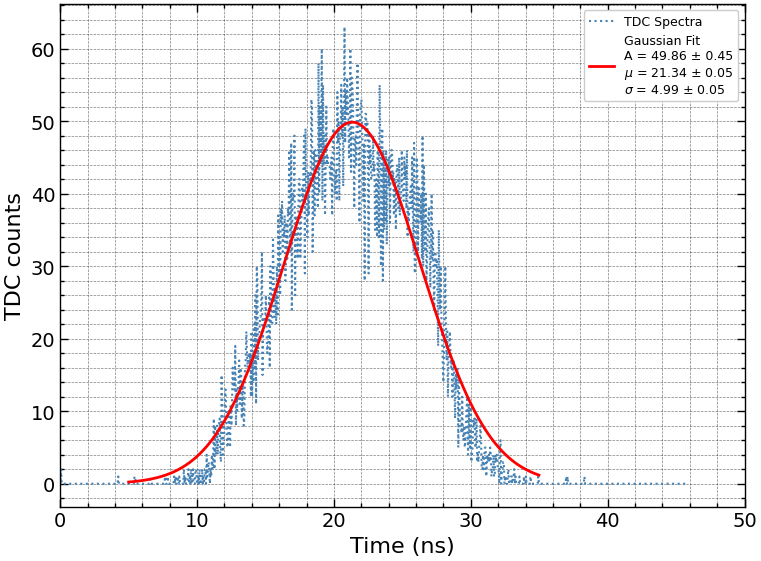

(array([  45.6618,   45.6143,   45.5668, ..., -148.7082, -148.7557,
        -148.8032]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
get_tdc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.1/sec5_3_1_A+C_chC_tdc_c.txt",
    xlim=(0, 50),
    cal_pmt_c=True,
    gaussian_fit=True,
    print_area=True,
)

### Intensity and energy loss


### NOTE: For this section, we fucked-up again, the new lab manual says PMT A and PMT C, we took C and D :')

Taking other team's data for this part


### ADC Spectra of PMT A


Calibration used: PMT-A: Energy (MeV) = (9.23 * Channel + (-1679.32)) / 1000
Moyal Fit Parameters:
Mu (Location): 1.2065 ± 0.0089
Sigma (Scale): 0.4513 ± 0.0066
Amplitude: 120.8067 ± 1.4416


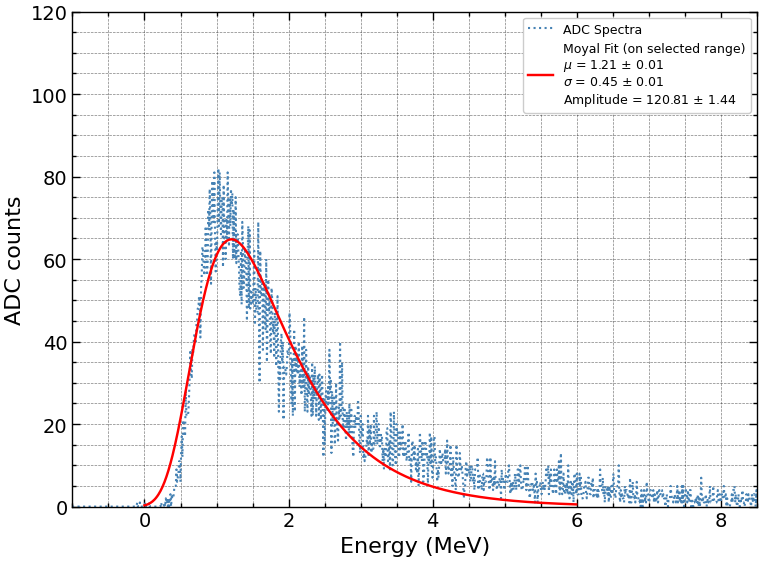

(array([-1.67009, -1.66086, -1.65163, ...,  8.81519,  8.82442,  8.83365]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
get_adc_spectra_new(
    "/Users/sayakghosh/Downloads/shivani-needhi/5.3.1/test_adc_a.txt",
    perform_fit=True,
    cal_pmt_a=True,
    xlim=(-1, 8.5),
    ylim=(0, 120),
    print_area=True,
)

### ADC Spectra of PMT C


Calibration used: PMT-C: Energy (MeV) = (19.56 * Channel + (-1995.46)) / 1000
Moyal Fit Parameters:
Mu (Location): 2.4475 ± 0.0322
Sigma (Scale): 1.2712 ± 0.0266
Amplitude: 229.5416 ± 3.7135


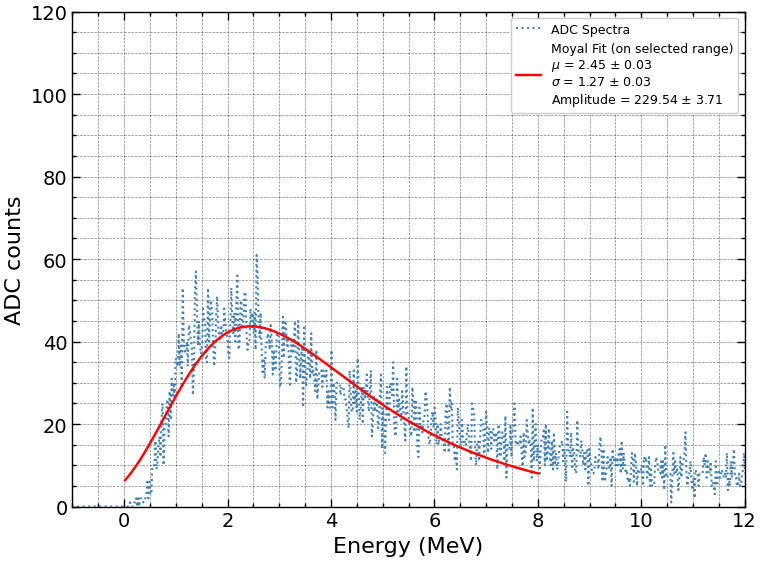

(array([-1.9759 , -1.95634, -1.93678, ..., 20.24426, 20.26382, 20.28338]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [ ]:
get_adc_spectra_new(
    "/Users/sayakghosh/Downloads/shivani-needhi/5.3.1/test_adc_c.txt",
    perform_fit=True,
    cal_pmt_c=True,
    xlim=(-1, 12),
    ylim=(0, 120),
    print_area=True,
)

## Section 5.3.4


### Electromagnetic and muonic component


### PMT-A "WITH" lead


Calibration used: PMT-A: Energy (MeV) = 0.007952 * Channel + -1.447351
Moyal Fit Parameters (with errors):
Mu (Location): 0.83596 ± 0.00560
Sigma (Scale): 0.27998 ± 0.00415
Amplitude: 49.93375 ± 0.60104


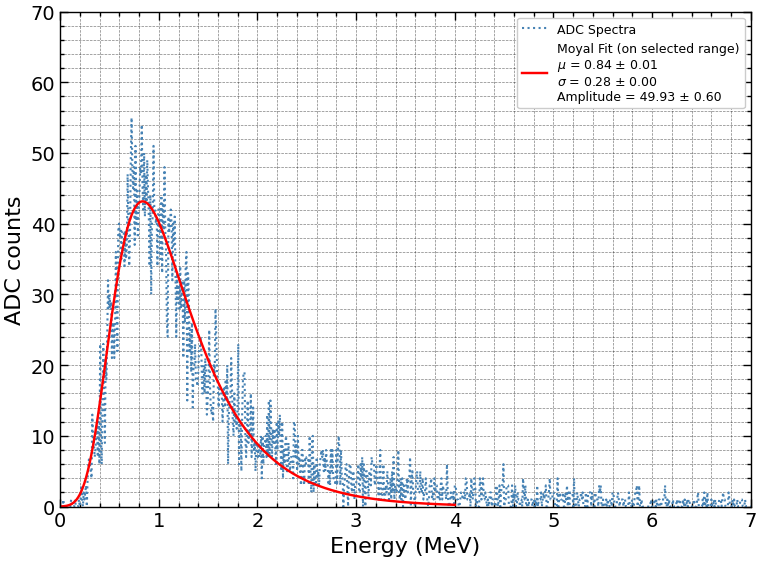

(array([-1.439399, -1.431447, -1.423495, ...,  7.594073,  7.602025,
         7.609977]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [71]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.4/sec5_3_4_A+C_adc_a.txt",
    xlim=(0, 7),
    ylim=(0, 70),
    cal_pmt_a=True,
)

### PMT-A "WITH" lead


Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 1.08666 ± 0.01177
Sigma (Scale): 0.46795 ± 0.00894
Amplitude: 68.91539 ± 1.05555
Total counts (area under fit): 66.35
Moyal Fit Parameters (with errors):
Mu (Location): 1.08666 ± 0.01177
Sigma (Scale): 0.46795 ± 0.00894
Amplitude: 68.91539 ± 1.05555
Total counts (area under fit): 66.35


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


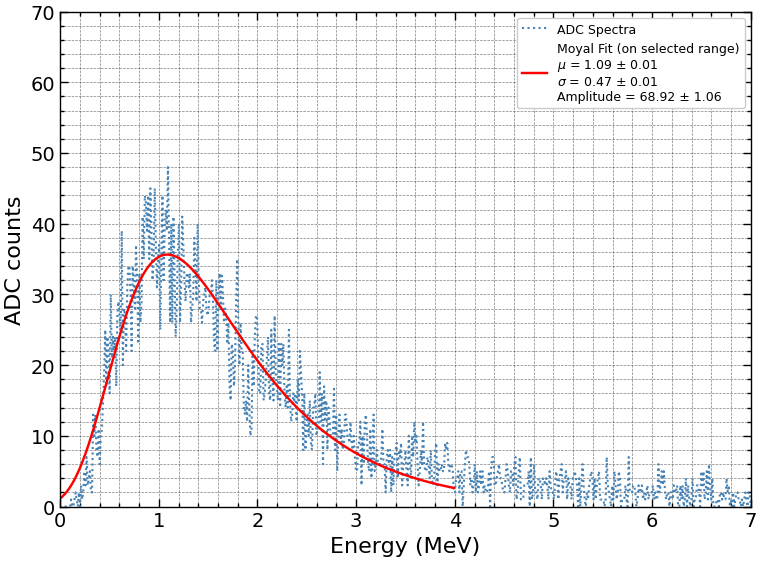

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [93]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.4/sec5_3_4_A+C_adc_c.txt",
    xlim=(0, 7),
    ylim=(0, 70),
    cal_pmt_c=True,
    print_area=True,
)

## Section 5.3.5


### Speed and zenith angle dependence of muons


File 1: PMT-C: Time (ns) = -0.0475 * Channel + 45.7093
File 2: PMT-C: Time (ns) = -0.0475 * Channel + 45.7093
Fit pos: 0°:
  Amplitude = 5.81 ± 0.12
  Mu = 17.80 ± 0.09
  Sigma = 3.90 ± 0.09
Fit pos: 180°:
  Amplitude = 4.95 ± 0.11
  Mu = 26.01 ± 0.10
  Sigma = 3.72 ± 0.10


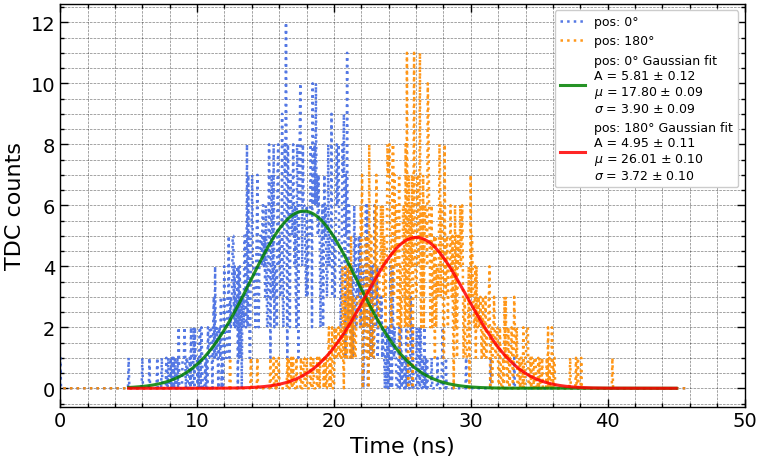

((array([  45.6618,   45.6143,   45.5668, ..., -148.7082, -148.7557,
         -148.8032]),
  array([0., 0., 0., ..., 0., 0., 0.])),
 (array([  45.6618,   45.6143,   45.5668, ..., -148.7082, -148.7557,
         -148.8032]),
  array([0., 0., 0., ..., 0., 0., 0.])))

In [ ]:
get_tdc_spectra_dual(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_0_degree_tdc_c.txt",
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_180_degree_tdc_c.txt",
    cal_pmt_1={"c": True},  # or {"b":True}, ... or None
    cal_pmt_2={"c": True},
    gaussian_fit1=True,
    gaussian_fit2=True,
    label1="pos: 0°",
    label2="pos: 180°",
    xlim=(0, 50),
    print_area=True,
)

## Zenith angle dependance


Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 0.96281 ± 0.02983
Sigma (Scale): 0.47357 ± 0.02296
Amplitude: 10.54514 ± 0.40662
Total counts (area under fit): 10.14


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


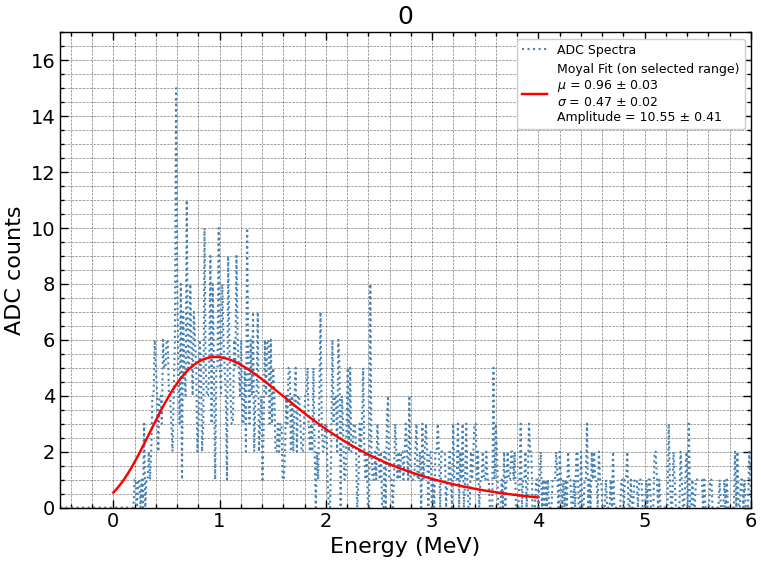

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [105]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_0_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 0.93563 ± 0.02877
Sigma (Scale): 0.44132 ± 0.02186
Amplitude: 9.69121 ± 0.38456
Total counts (area under fit): 9.41


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


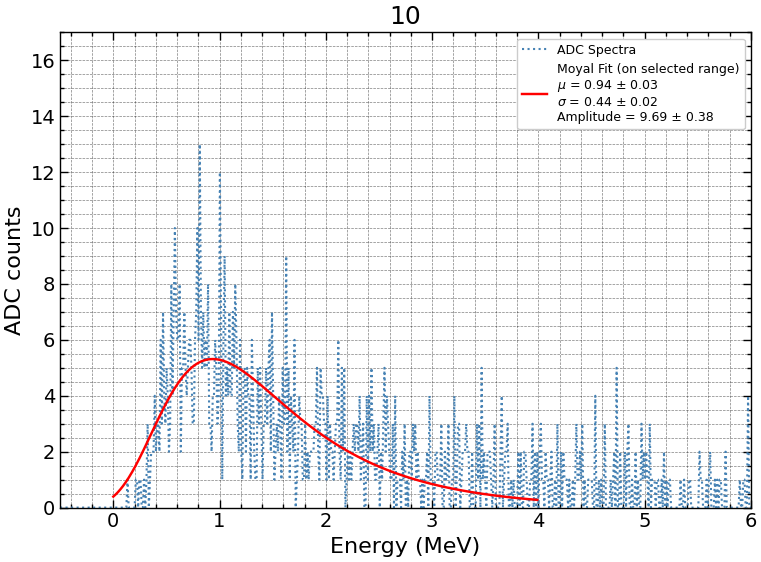

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [106]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_10_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 0.97861 ± 0.03167
Sigma (Scale): 0.48077 ± 0.02442
Amplitude: 9.18507 ± 0.37078
Total counts (area under fit): 8.81


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


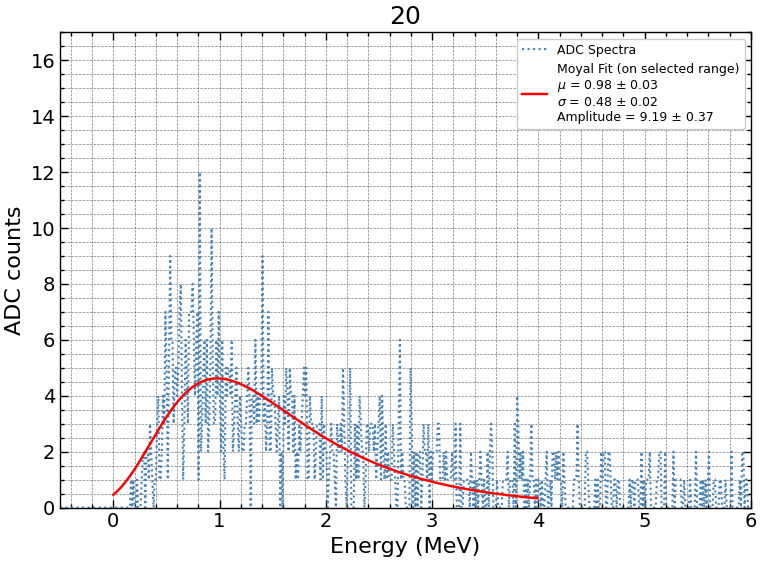

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [107]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_20_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 0.94853 ± 0.03069
Sigma (Scale): 0.44741 ± 0.02335
Amplitude: 7.73005 ± 0.32296
Total counts (area under fit): 7.49


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


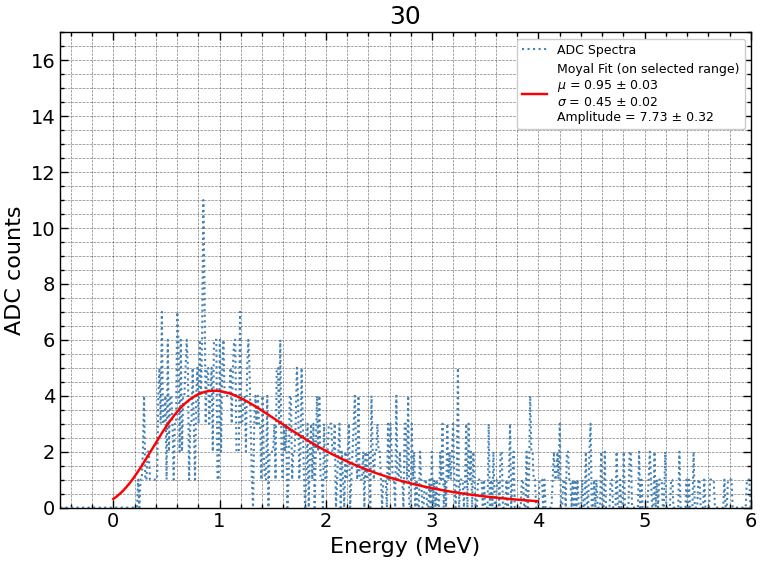

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [108]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_30_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 0.94311 ± 0.03946
Sigma (Scale): 0.46491 ± 0.03032
Amplitude: 5.32361 ± 0.27635
Total counts (area under fit): 5.13


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


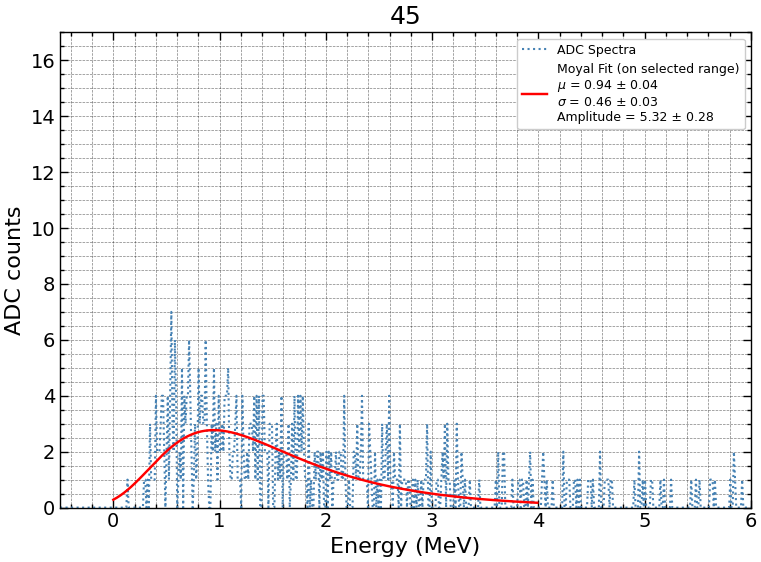

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [109]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_45_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 1.52066 ± 0.16800
Sigma (Scale): 0.74561 ± 0.14387
Amplitude: 1.07677 ± 0.16013
Total counts (area under fit): 0.91


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


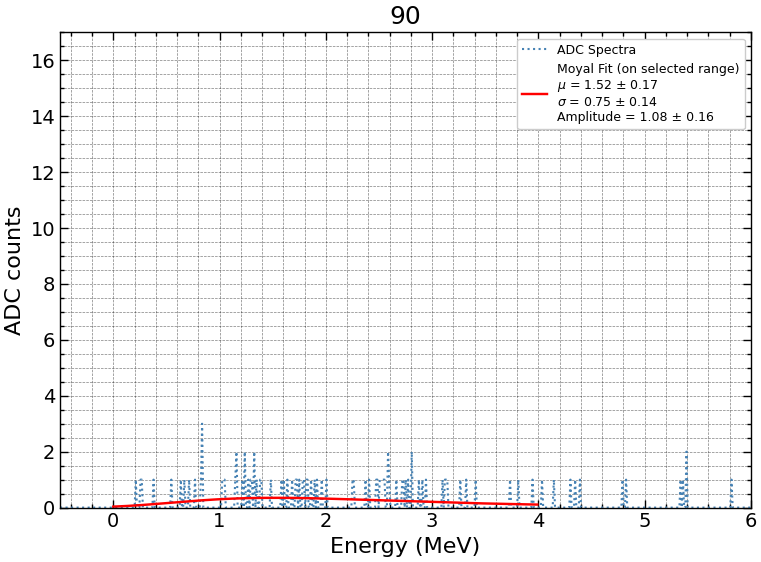

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [110]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_90_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Calibration used: PMT-C: Energy (MeV) = 0.011146 * Channel + -1.370921
Moyal Fit Parameters (with errors):
Mu (Location): 0.92380 ± 0.03299
Sigma (Scale): 0.45673 ± 0.02532
Amplitude: 7.85843 ± 0.34689
Total counts (area under fit): 7.59


/var/folders/wj/k99vprr92qldz634zv4211ch0000gn/T/ipykernel_70737/2092767243.py:116: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(moyal_func(x_fit, *popt), x_fit)


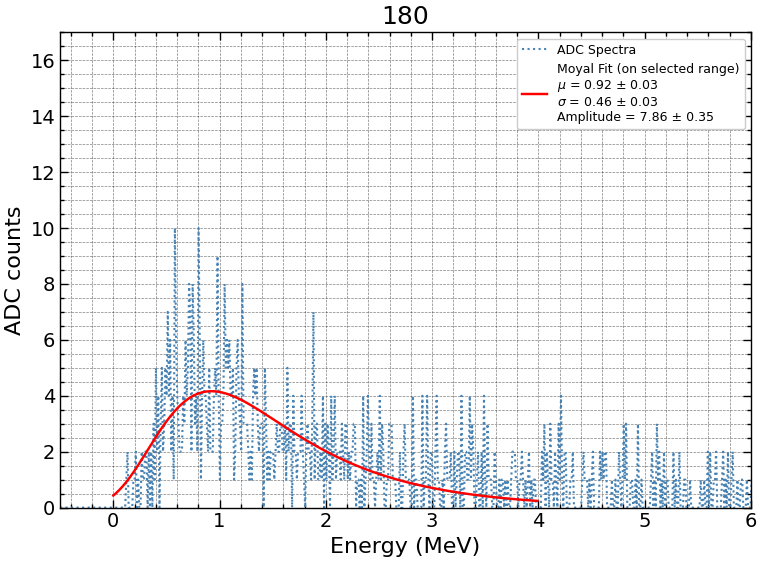

(array([-1.359775, -1.348629, -1.337483, ..., 11.302081, 11.313227,
        11.324373]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [111]:
get_adc_spectra(
    "/Users/sayakghosh/Downloads/M19 Cosmic Rays/5.3.5/sec5_3_5_A+C_180_degree_adc_c.txt",
    ylim=(0, 17),
    xlim=(-0.5, 6),
    cal_pmt_c=True,
    print_area=True,
)

Fitted parameters with uncertainties:
f0 = 86.04 ± 6.09
t = 9.14 ± 4.90


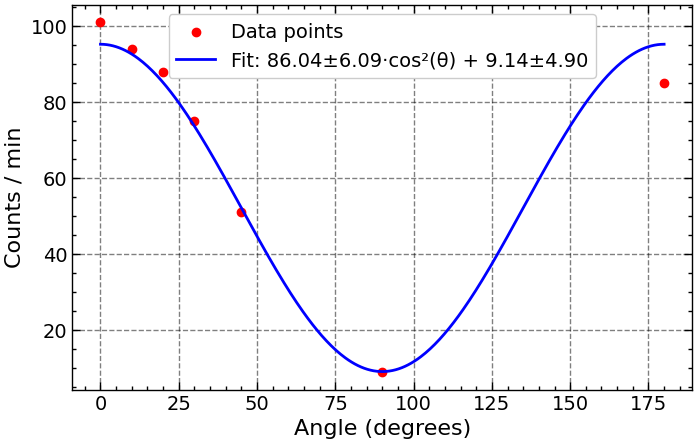

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data
angles_deg = np.array([0, 10, 20, 30, 45, 90, 180])
counts_per_min = np.array([101, 94, 88, 75, 51, 9, 85])

# Convert degrees to radians for the cosine function
angles_rad = np.deg2rad(angles_deg)


# Define the model function f(θ) = f0 * cos^2(θ) + t
def model(theta, f0, t):
    return f0 * np.cos(theta) ** 2 + t


# Perform curve fitting
params, covariance = curve_fit(model, angles_rad, counts_per_min, p0=[100, 0])

f0_fit, t_fit = params
# Calculate standard deviation errors from the covariance matrix
errors = np.sqrt(np.diag(covariance))
f0_err, t_err = errors

print(f"Fitted parameters with uncertainties:")
print(f"f0 = {f0_fit:.2f} ± {f0_err:.2f}")
print(f"t = {t_fit:.2f} ± {t_err:.2f}")

# Generate smooth curve data for the fit
angles_fit_deg = np.linspace(0, 180, 360)
angles_fit_rad = np.deg2rad(angles_fit_deg)
counts_fit = model(angles_fit_rad, f0_fit, t_fit)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(angles_deg, counts_per_min, color="red", label="Data points")
plt.plot(
    angles_fit_deg,
    counts_fit,
    label=f"Fit: {f0_fit:.2f}±{f0_err:.2f}·cos²(θ) + {t_fit:.2f}±{t_err:.2f}",
    color="blue",
)
plt.xlabel("Angle (degrees)")
plt.ylabel("Counts / min")
plt.grid(True)
plt.legend()
plt.show()